In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from math import sqrt

# Part 1

In [2]:
# Loading in the data
# Quick tutorial of Pandas : https://pandas.pydata.org/pandas-docs/stable/10min.html
# Other tutorial : https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python
file_path = os.path.expanduser('~/Documents/GitHub/ee219/Project 4/network_backup_dataset.csv')
df = pd.read_csv(file_path)

In [3]:
# Preprocessing data by adding a 'Day #' column
def days_to_num(day_of_week):
    days_to_num_map = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
    
    num = []
    for i in xrange(0, len(day_of_week)):
        num.append(days_to_num_map[day_of_week[i]])
    return num

# Day number = 7*(Week # - 1)  + days_of_week
# There are a total of  105 days. 
df['Day #'] = 7*(df['Week #'] - 1) + days_to_num(df['Day of Week'])
max(df['Day #'])

105L

## Section 1.a

In [4]:
# Extracting the first 20 days
twenty_day_period = df[df['Day #'].map(lambda i : i <= 20)]

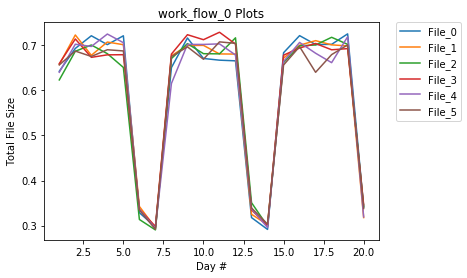

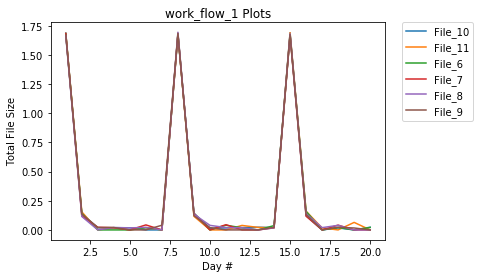

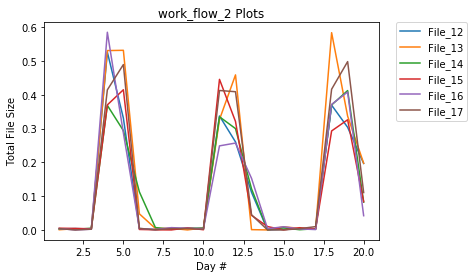

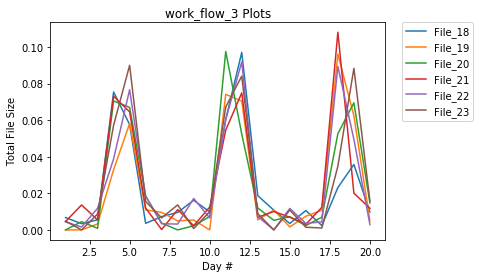

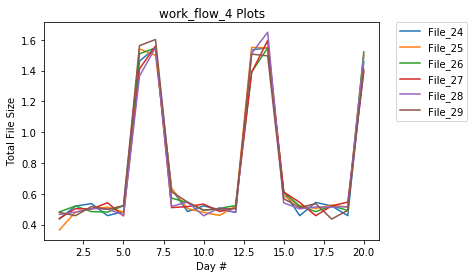

In [5]:
# Grouping all the work-flow-ids together
x = range(1,21,1)
for wfID, wfGrouped in twenty_day_period.groupby('Work-Flow-ID'):
    
    plt.figure()
    plt.title('%s Plots' % wfID)
    plt.xlabel('Day #')
    plt.ylabel('Total File Size')
    
    # Grouping all the files in the work-flow together
    for fID, fGrouped in wfGrouped.groupby('File Name'):
        
        # Grouping all the days in the work-flow togeter and summing it up
        sum_by_day = fGrouped.groupby('Day #').sum()
        
        # Plot
        plt.plot(x, sum_by_day['Size of Backup (GB)'], label=fID)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
        

## Section 1.b

In [6]:
# Extracting the first 105 days
first_105_days = df[df['Day #'].map(lambda i : i <= 105)]

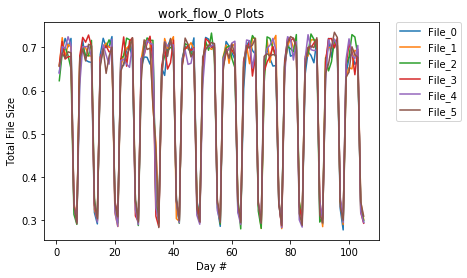

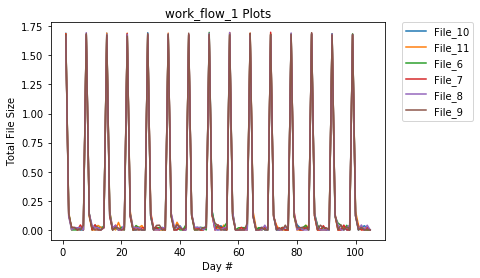

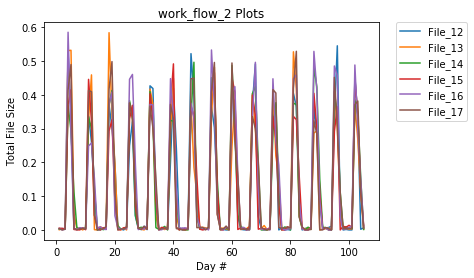

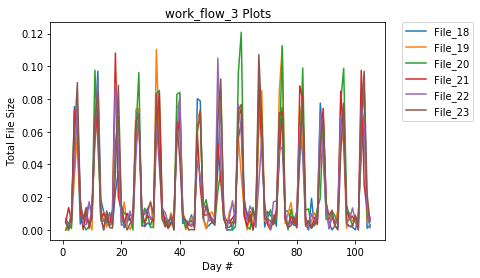

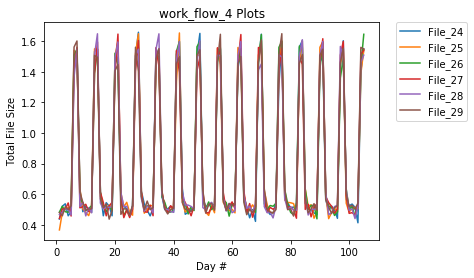

In [7]:
# Grouping all the work-flow-ids together
x = range(1,106,1)
for wfID, wfGrouped in first_105_days.groupby('Work-Flow-ID'):
    
    plt.figure()
    plt.title('%s Plots' % wfID)
    plt.xlabel('Day #')
    plt.ylabel('Total File Size')
    
    # Grouping all the files in the work-flow together
    for fID, fGrouped in wfGrouped.groupby('File Name'):
        
        # Grouping all the days in the work-flow togeter and summing it up
        sum_by_day = fGrouped.groupby('Day #').sum()
        
        # Plot
        plt.plot(x, sum_by_day['Size of Backup (GB)'], label=fID)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 

# Part 2

## Section 2.a.i

In [8]:
# part i: Converting each each catorgoical feature into 1D values
df_1d = pd.read_csv(file_path)
df_1d.drop('Backup Time (hour)', axis = 1) # We do not use backup time in prediction
def underscore_str_to_num(str_array):
    num = []
    for i in xrange(0,len(str_array)):
        val = [int(s) for s in str_array[i].split('_') if s.isdigit()]
        num.append(val[0]) ## We do this so we get a scalar not an array of 1
    return num
    
df_1d['Day of Week'] = days_to_num(df_1d['Day of Week'])
df_1d['Work-Flow-ID'] = underscore_str_to_num(df_1d['Work-Flow-ID'])
df_1d['File Name'] = underscore_str_to_num(df_1d['File Name'])

In [9]:
x = ['Week #','Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID','File Name']
y = ['Size of Backup (GB)']

linReg = LinearRegression(normalize = True)
kf = KFold(n_splits = 10, shuffle = True, random_state = 42)

sum_RMSE_train = 0
sum_RMSE_test = 0

y_actual = df_1d.loc[ : , lambda df_1d : y].as_matrix()

for trainIndex, testIndex in kf.split(df_1d):
    # Set up training data
    x_trainSet = df_1d.loc[trainIndex, lambda df_1d : x]
    y_trainSet = df_1d.loc[trainIndex, lambda df_1d : y]
    
    # Set up testing data
    x_testSet = df_1d.loc[testIndex, lambda df_1d : x]
    y_testSet = df_1d.loc[testIndex, lambda df_1d : y] # actual
    
    # Train model using training sets
    linReg.fit(x_trainSet, y_trainSet)
    
    # Make predictions using the testing set
    y_pred_train = linReg.predict(x_trainSet)
    y_pred_test = linReg.predict(x_testSet)
    
    # Sum all RMSE
    sum_RMSE_train = sum_RMSE_train + mean_squared_error(y_trainSet, y_pred_train)
    sum_RMSE_test = sum_RMSE_test + mean_squared_error(y_testSet, y_pred_test)

RMSE_train = sqrt(sum_RMSE_train / 10)
RMSE_test = sqrt(sum_RMSE_test / 10)
print 'Training RMSE:', RMSE_train
print 'Test RMSE:', RMSE_test

#cross validation returns prediction
features = df_1d.loc[ : , lambda df_1d : x]
# y_pred = cross_val_predict(linReg, features, y_actual, cv=10)
linReg.fit(features, y_actual)
# y_pred = cross_val_predict(linReg, features_fitted, y_actual, cv=10)
y_pred_wo = linReg.predict(features)
print linReg.coef_
print linReg.intercept_

Training RMSE: 0.103587470756
Test RMSE: 0.103635058768
[[ 1.71674482e-05 -2.37717728e-03  1.36734990e-03  2.39021236e-03
   4.56647178e-05]]
[0.04996456]


Text(0,0.5,u'Fitted and Actual')

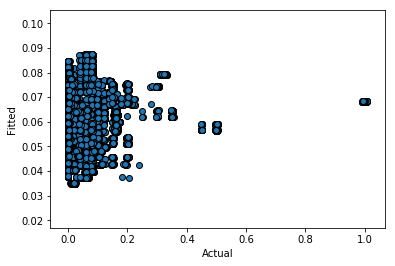

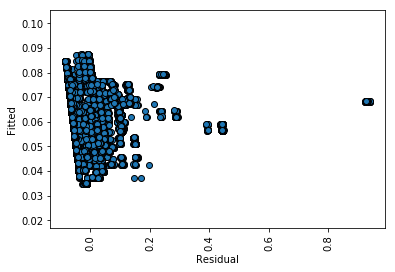

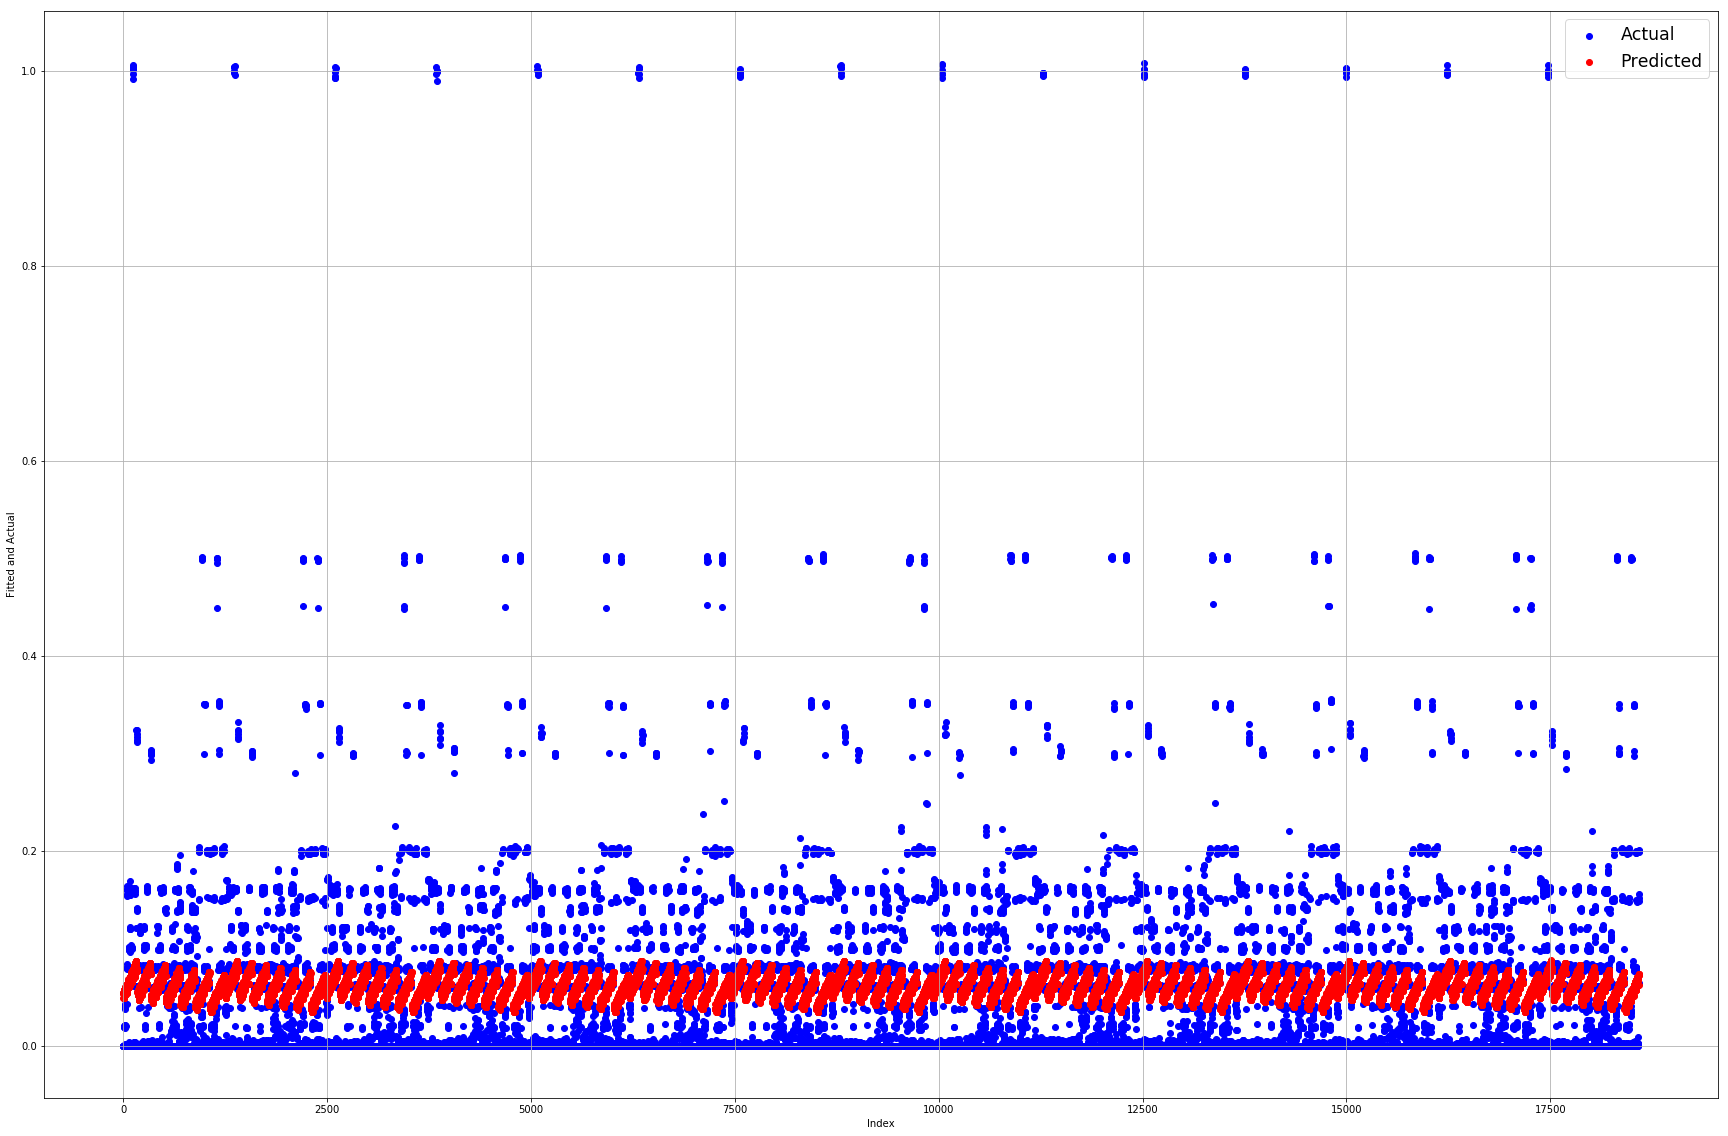

In [15]:
#Plot graph as Fitted vs Actual
plt.figure()
plt.scatter(x=y_actual, y=y_pred_wo, edgecolors=(0, 0, 0))
plt.xlabel('Actual')
plt.ylabel('Fitted')

#Plot residual
residual = y_actual - y_pred_wo

plt.figure()
plt.xticks(rotation='vertical')
plt.scatter(x=residual, y=y_pred_wo, edgecolors=(0, 0, 0))
plt.xlabel('Residual')
plt.ylabel('Fitted')
plt.xlim((min(residual) - 0.05, max(residual) +0.05))

#Plot graph as Value vs Index
plt.figure(figsize=((30,20)))
plt.grid(True)
p1 = plt.scatter(y=y_actual, x=range(0,len(y_pred_wo)), color= 'blue')
p2 = plt.scatter(y=y_pred_wo, x=range(0,len(y_pred_wo)), color = 'red')
plt.legend((p1, p2), ('Actual', 'Predicted'), fontsize = 'xx-large')

plt.xlabel('Index')
plt.ylabel('Fitted and Actual')

## Section 2.a.ii

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
x = ['Week #','Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID','File Name']
y = ['Size of Backup (GB)']

# Satndarizing all the features Function
features = df_1d.loc[ : , lambda df_1d : x]
scaler = StandardScaler()
scaler.fit(features)
features_fitted = scaler.transform(features)

In [18]:
linReg = LinearRegression()
kf = KFold(n_splits = 10, shuffle = True, random_state = 42)

sum_RMSE_train = 0
sum_RMSE_test = 0

y_actual = df_1d.loc[ : , lambda df_1d : y].as_matrix()
print features_fitted

for trainIndex, testIndex in kf.split(features_fitted):
    # Set up training data
    x_trainSet = features_fitted[trainIndex]
    y_trainSet = df_1d.loc[trainIndex, lambda df_1d : y]
    # Set up testing data
    x_testSet = features_fitted[testIndex]
    y_testSet = df_1d.loc[testIndex, lambda df_1d : y] # actual
    
    # Train model using training sets
    linReg.fit(x_trainSet, y_trainSet)
    
    # Make predictions using the testing set
    y_pred_train = linReg.predict(x_trainSet)
    y_pred_test = linReg.predict(x_testSet)
    
    # Calculating RMSE
    sum_RMSE_train = sum_RMSE_train + mean_squared_error(y_trainSet, y_pred_train)
    sum_RMSE_test = sum_RMSE_test + mean_squared_error(y_testSet, y_pred_test)

RMSE_train = sqrt(sum_RMSE_train / 10)
RMSE_test = sqrt(sum_RMSE_test / 10)
print 'Training RMSE:', RMSE_train
print 'Test RMSE:', RMSE_test

#cross validation returns prediction
linReg.fit(features_fitted, y_actual)
y_pred = linReg.predict(features_fitted)
print linReg.coef_
print linReg.intercept_

[[-1.62003968 -1.51932107 -1.455772   -1.42689367 -1.68739471]
 [-1.62003968 -1.51932107 -1.455772   -0.0139109  -0.30219057]
 [-1.62003968 -1.51932107 -1.455772   -0.0139109  -0.18675689]
 ...
 [ 1.62051288  1.48761463  1.47082378  1.39907186  1.31388094]
 [ 1.62051288  1.48761463  1.47082378  1.39907186  1.19844726]
 [ 1.62051288  1.48761463  1.47082378  1.39907186  1.08301358]]
Training RMSE: 0.103587470756
Test RMSE: 0.103635058768
[[ 7.41676829e-05 -4.74338832e-03  9.34430312e-03  3.38321517e-03
   3.95592675e-04]]
[0.06098351]


Text(0,0.5,u'Fitted and Actual')

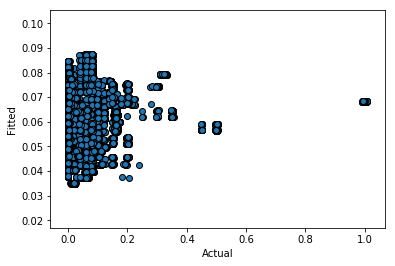

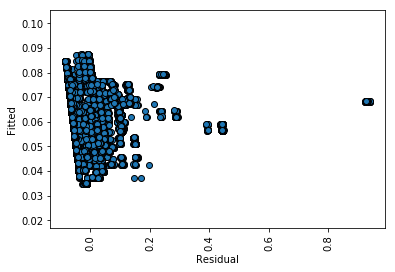

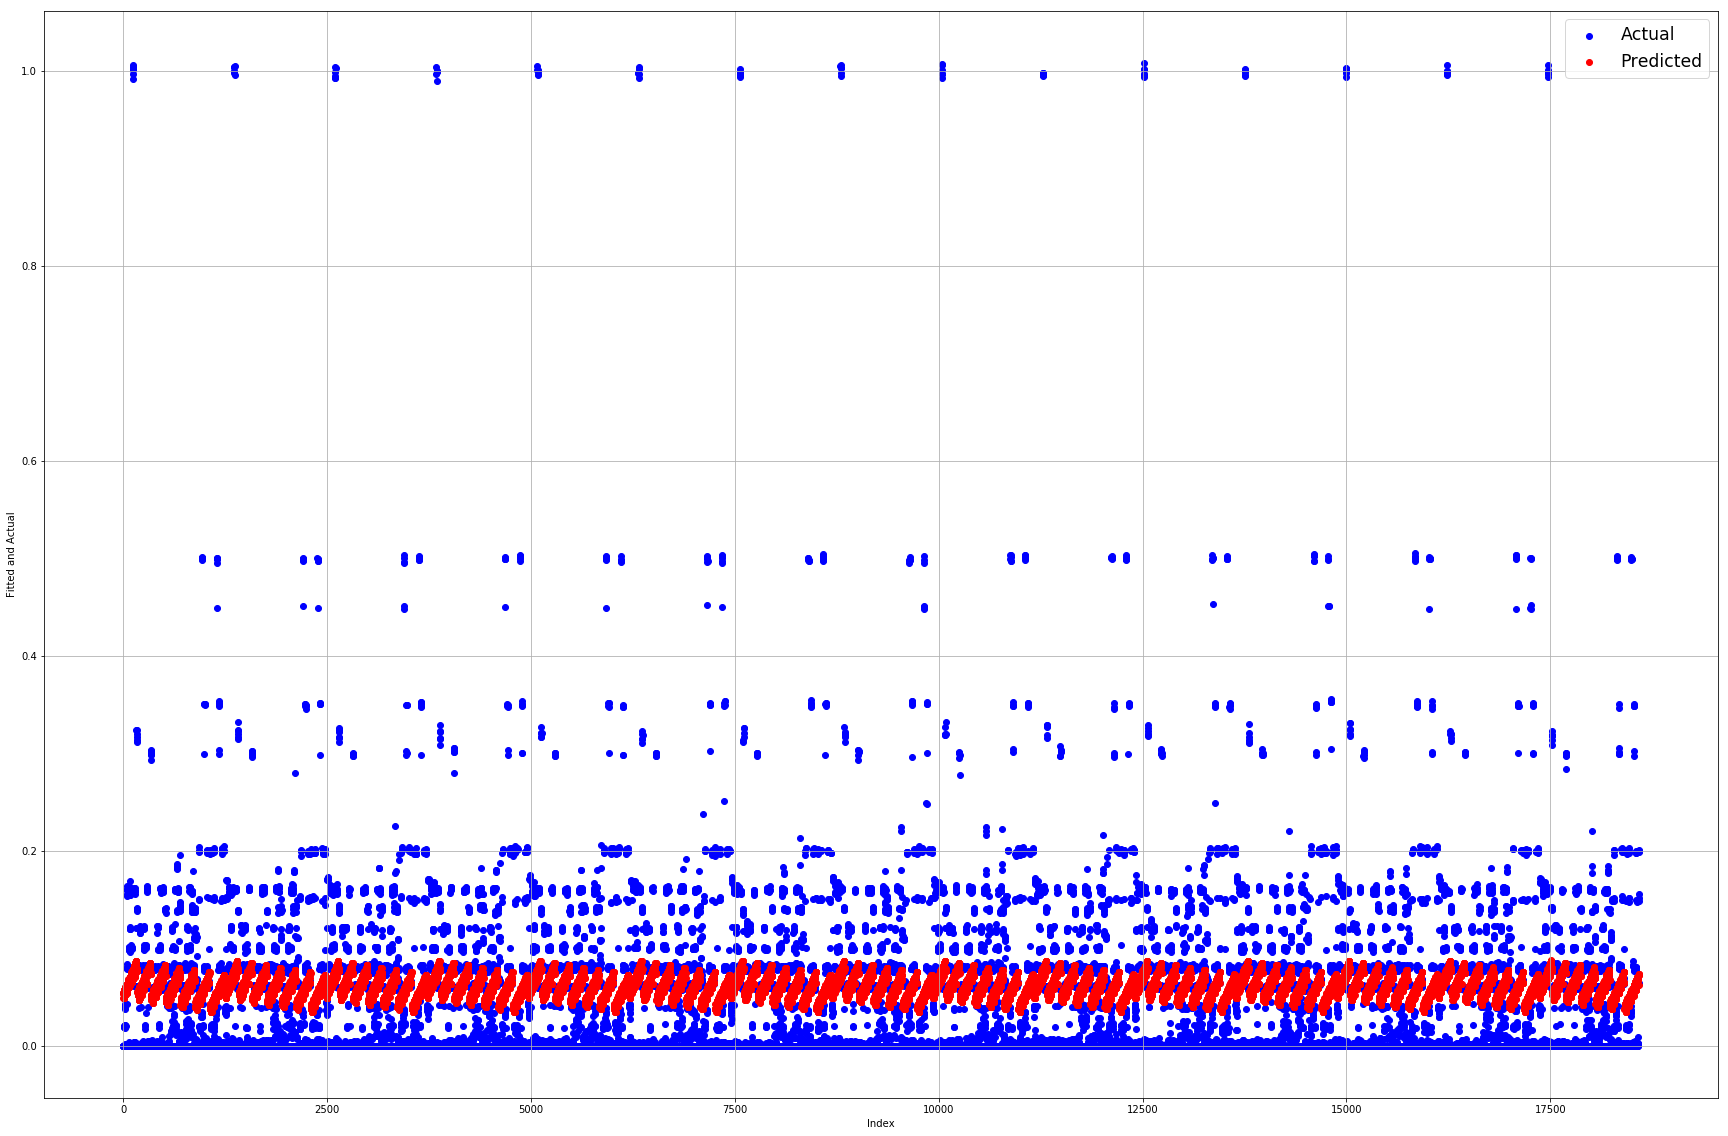

In [19]:
#Plot graph as Fitted vs Actual
plt.figure()
plt.scatter(x=y_actual, y=y_pred, edgecolors=(0, 0, 0))
plt.xlabel('Actual')
plt.ylabel('Fitted')

#Plot residual
residual = y_actual - y_pred

plt.figure()
plt.xticks(rotation='vertical')
plt.scatter(x=residual, y=y_pred, edgecolors=(0, 0, 0))
plt.xlabel('Residual')
plt.ylabel('Fitted')
plt.xlim((min(residual) - 0.05, max(residual) +0.05))

#Plot graphs as Value vs Index
plt.figure(figsize=((30,20)))
plt.grid(True)
p1 = plt.scatter(y=y_actual, x=range(0,len(y_pred)), color= 'blue')
p2 = plt.scatter(y=y_pred, x=range(0,len(y_pred)), color = 'red')
plt.legend((p1, p2), ('Actual', 'Predicted'), fontsize = 'xx-large')

plt.xlabel('Index')
plt.ylabel('Fitted and Actual')

Text(0,0.5,u'Fitted and Actual')

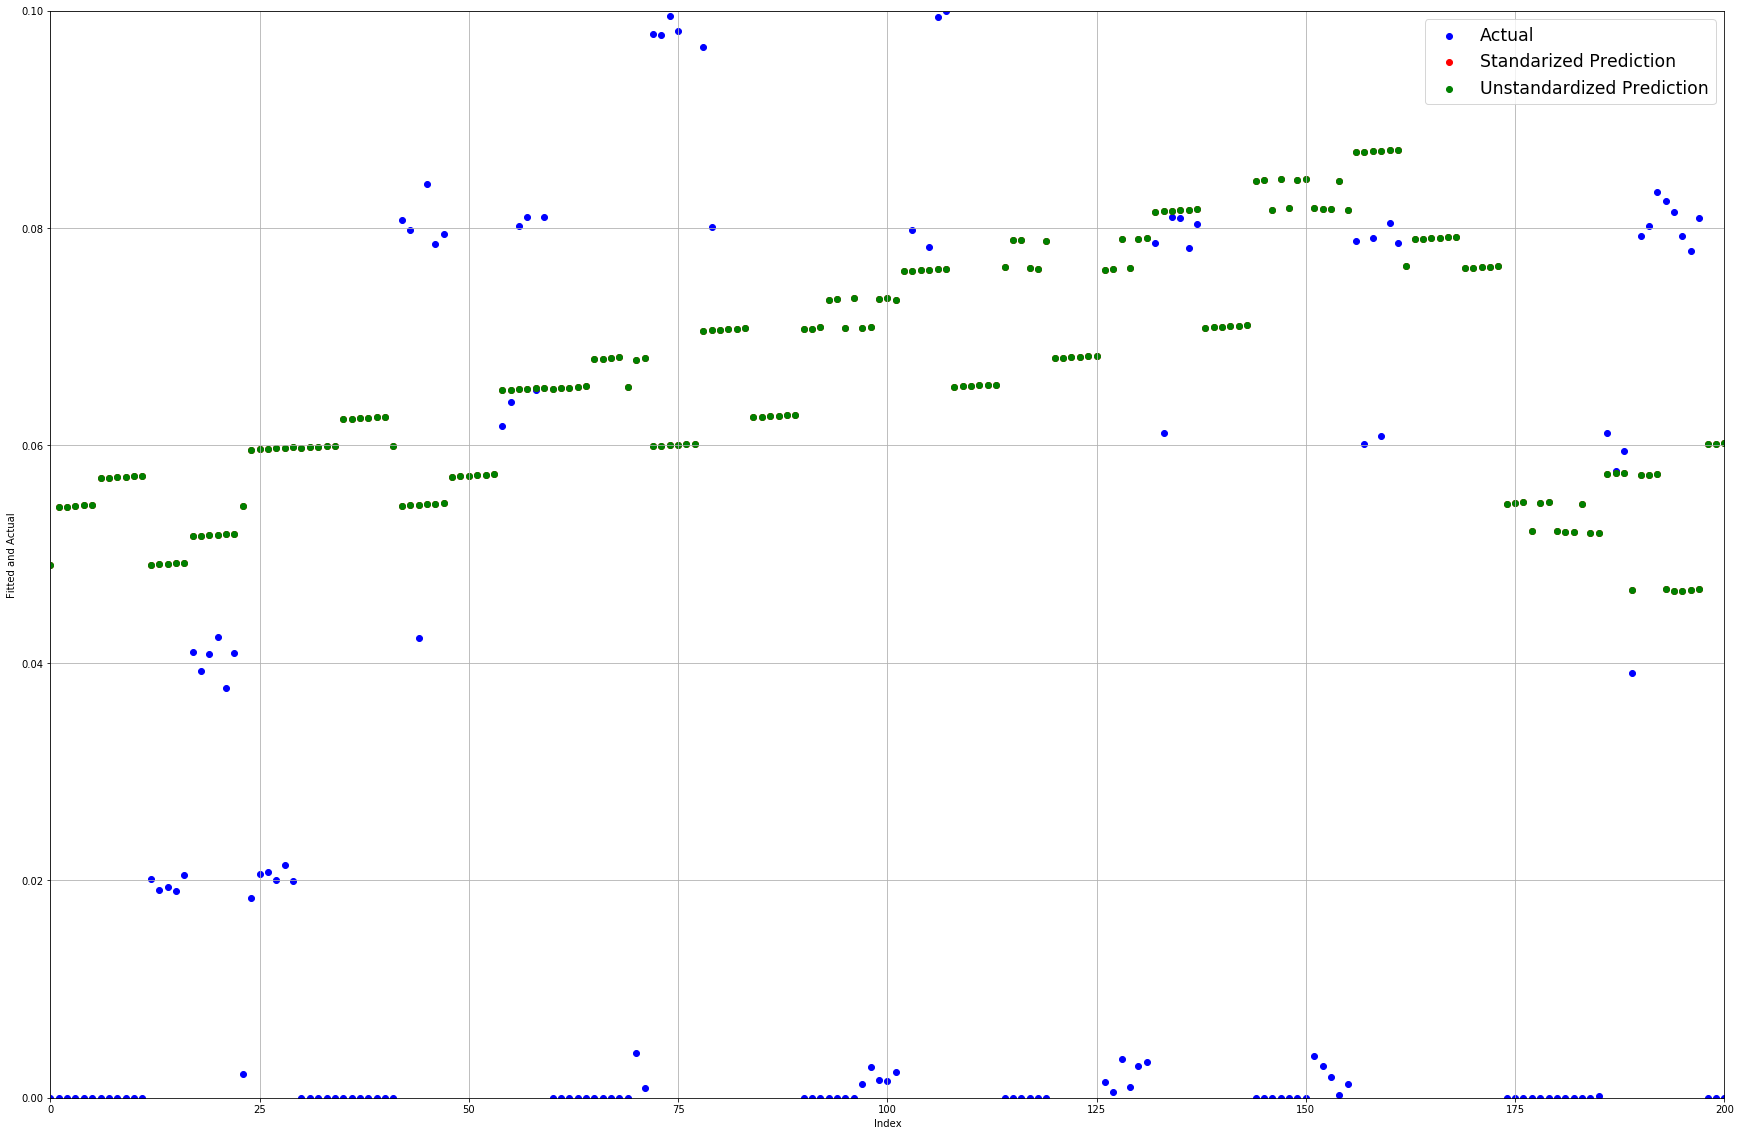

In [20]:
#Plot graphs as Value vs Index

plt.figure(figsize=((30,20)))
plt.ylim([0, 0.1])
plt.xlim([0, 200])
plt.grid(True)
p1 = plt.scatter(y=y_actual, x=range(0,len(y_pred)), color= 'blue')
p2 = plt.scatter(y=y_pred, x=range(0,len(y_pred)), color = 'red')
p3 = plt.scatter(y=y_pred_wo, x=range(0,len(y_pred)), color = 'green')
plt.legend((p1,p2,p3), ('Actual', 'Standarized Prediction','Unstandardized Prediction'), fontsize = 'xx-large')
plt.xlabel('Index')
plt.ylabel('Fitted and Actual')

## Section 2.a.iii

In [21]:
from sklearn.feature_selection import f_regression, mutual_info_regression

In [22]:
#Feature Selection, find top 3
f_test, _ = f_regression(features, y_actual.ravel())
mi = mutual_info_regression(features, y_actual.ravel())

#keeping top 3 features
print f_test
print mi

top3_features = features.drop('Week #', axis = 1)
top3_features = top3_features.drop('Work-Flow-ID', axis = 1)

top3_f_test, _ = f_regression(top3_features, y_actual.ravel())
top3_mi = mutual_info_regression(top3_features, y_actual.ravel())

print 'Top 3 variables: Day of Week, Backup Start Time - Hour of Day, File Name'
print top3_f_test
print top3_mi

c:\python27\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


[8.45006257e-03 3.88163798e+01 1.50740934e+02 2.61386654e+01
 2.53200943e+01]
[0.         0.22622102 0.23096466 0.26933312 0.43403574]
Top 3 variables: Day of Week, Backup Start Time - Hour of Day, File Name
[ 38.81637983 150.74093437  25.32009433]
[0.23002362 0.23816789 0.43560558]


In [24]:
#Repeat with Top 3 features
x = ['Day of Week', 'Backup Start Time - Hour of Day','File Name']
y = ['Size of Backup (GB)']

linReg = LinearRegression(normalize = True)
kf = KFold(n_splits = 10, shuffle = True, random_state = 42)

sum_RMSE_train = 0
sum_RMSE_test = 0

y_actual = df_1d.loc[ : , lambda df_1d : y].as_matrix()

for trainIndex, testIndex in kf.split(top3_features):
    # Set up training data
    x_trainSet = top3_features.loc[trainIndex, lambda top3_features : x]
    y_trainSet = df_1d.loc[trainIndex, lambda df_1d : y]
    
    # Set up testing data
    x_testSet = top3_features.loc[testIndex, lambda top3_features : x]
    y_testSet = df_1d.loc[testIndex, lambda df_1d : y] # actual
    
    # Train model using training sets
    linReg.fit(x_trainSet, y_trainSet)
    
    # Make predictions using the testing set
    y_pred_train = linReg.predict(x_trainSet)
    y_pred_test = linReg.predict(x_testSet)
    
    # Sum all RMSE
    sum_RMSE_train = sum_RMSE_train + mean_squared_error(y_trainSet, y_pred_train)
    sum_RMSE_test = sum_RMSE_test + mean_squared_error(y_testSet, y_pred_test)

RMSE_train = sqrt(sum_RMSE_train / 10)
RMSE_test = sqrt(sum_RMSE_test / 10)
print 'Training RMSE:', RMSE_train
print 'Test RMSE:', RMSE_test

#cross validation returns prediction
linReg.fit(top3_features, y_actual)
y_pred_wo = linReg.predict(top3_features)
print linReg.coef_
print linReg.intercept_

Training RMSE: 0.103590442631
Test RMSE: 0.103622085772
[[-0.00237818  0.00136749  0.00042853]]
[0.04933525]


Text(0,0.5,u'Fitted and Actual')

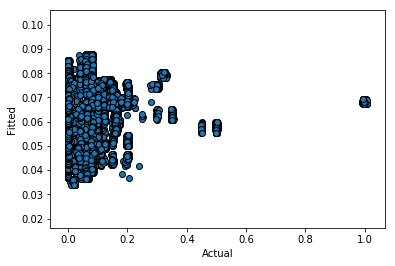

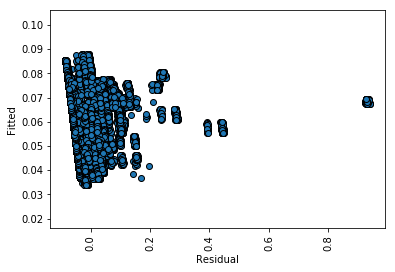

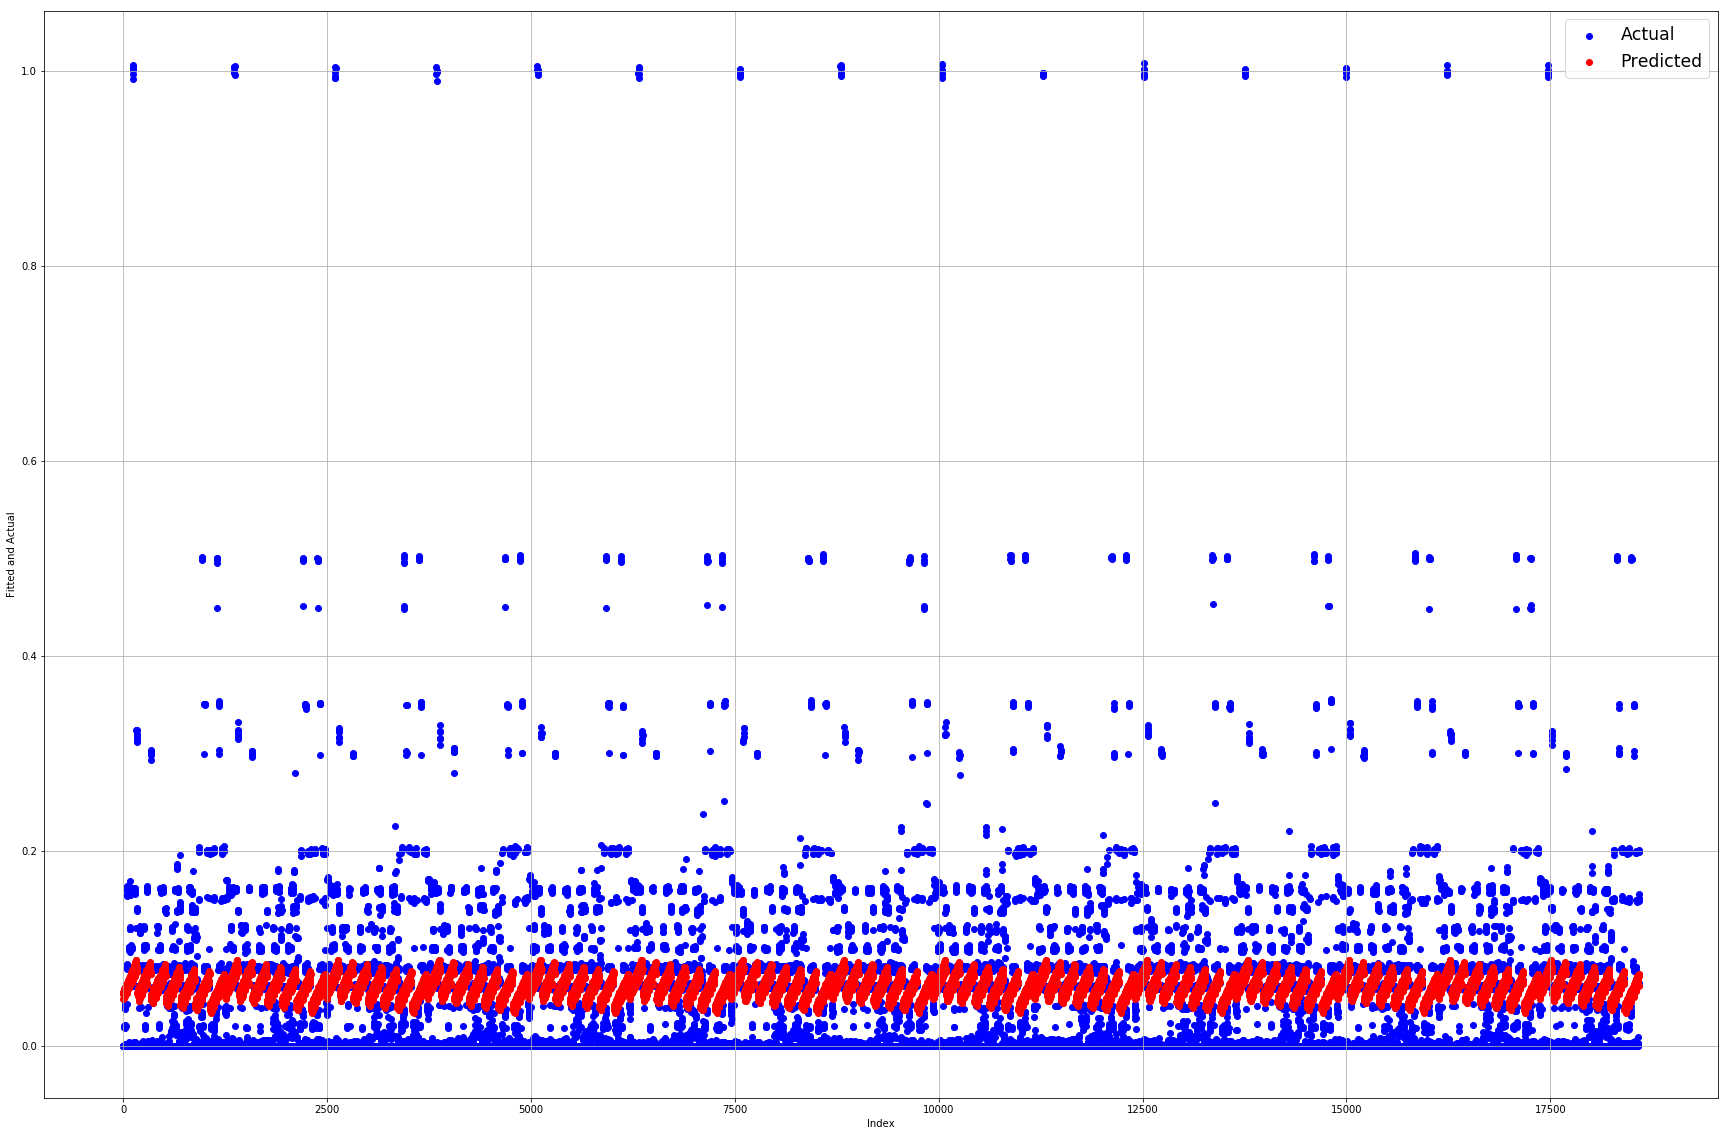

In [25]:
#Plot graph as Fitted vs Actual
plt.figure()
plt.scatter(x=y_actual, y=y_pred_wo, edgecolors=(0, 0, 0))
plt.xlabel('Actual')
plt.ylabel('Fitted')

#Plot residual
residual = y_actual - y_pred_wo

plt.figure()
plt.xticks(rotation='vertical')
plt.scatter(x=residual, y=y_pred_wo, edgecolors=(0, 0, 0))
plt.xlabel('Residual')
plt.ylabel('Fitted')
plt.xlim((min(residual) - 0.05, max(residual) +0.05))

#Plot graph as Value vs Index
plt.figure(figsize=((30,20)))
plt.grid(True)
p1 = plt.scatter(y=y_actual, x=range(0,len(y_pred_wo)), color= 'blue')
p2 = plt.scatter(y=y_pred_wo, x=range(0,len(y_pred_wo)), color = 'red')
plt.legend((p1, p2), ('Actual', 'Predicted'), fontsize = 'xx-large')

plt.xlabel('Index')
plt.ylabel('Fitted and Actual')

In [26]:
#Feature Selection, using Standardized Features
f_test, _ = f_regression(features_fitted, y_actual.ravel())
mi = mutual_info_regression(features_fitted, y_actual.ravel())

#keeping top 3 features
print f_test
print mi

top3_fitted_features = features_fitted[:,2:5]

print 'Top 3 variables: Backup Start Time - Hour of Day, Work-Flow-ID, File Name'
print '[1.50740934e+02 2.61386654e+01 2.53200943e+01]'
print '[0.30077338 0.77713356 0.77767688]'

[8.45006257e-03 3.88163798e+01 1.50740934e+02 2.61386654e+01
 2.53200943e+01]
[0.0025387  0.24054461 0.30523023 0.7666661  0.76913897]
Top 3 variables: Backup Start Time - Hour of Day, Work-Flow-ID, File Name
[1.50740934e+02 2.61386654e+01 2.53200943e+01]
[0.30077338 0.77713356 0.77767688]


In [29]:
#Repeat with Top 3 features, standardized
x = ['Backup Start Time - Hour of Day','Work-Flow-ID','File Name']
y = ['Size of Backup (GB)']

linReg = LinearRegression(normalize = True)
kf = KFold(n_splits = 10, shuffle = True, random_state = 42)

sum_RMSE_train = 0
sum_RMSE_test = 0

y_actual = df_1d.loc[ : , lambda df_1d : y].as_matrix()

for trainIndex, testIndex in kf.split(top3_fitted_features):
    # Set up training data
    x_trainSet = top3_fitted_features[trainIndex]
    y_trainSet = df_1d.loc[trainIndex, lambda df_1d : y]
    
    # Set up testing data
    x_testSet = top3_fitted_features[testIndex]
    y_testSet = df_1d.loc[testIndex, lambda df_1d : y] # actual
    
    # Train model using training sets
    linReg.fit(x_trainSet, y_trainSet)
    
    # Make predictions using the testing set
    y_pred_train = linReg.predict(x_trainSet)
    y_pred_test = linReg.predict(x_testSet)
    
    # Sum all RMSE
    sum_RMSE_train = sum_RMSE_train + mean_squared_error(y_trainSet, y_pred_train)
    sum_RMSE_test = sum_RMSE_test + mean_squared_error(y_testSet, y_pred_test)

RMSE_train = sqrt(sum_RMSE_train / 10)
RMSE_test = sqrt(sum_RMSE_test / 10)
print 'Training RMSE:', RMSE_train
print 'Test RMSE:', RMSE_test

#cross validation returns prediction
linReg.fit(top3_fitted_features, y_actual)
y_pred = linReg.predict(top3_fitted_features)
print linReg.coef_
print linReg.intercept_

Training RMSE: 0.103697046029
Test RMSE: 0.103723929364
[[0.0093207  0.00345539 0.00039727]]
[0.06098351]


Text(0,0.5,u'Fitted and Actual')

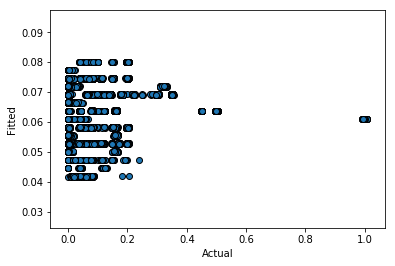

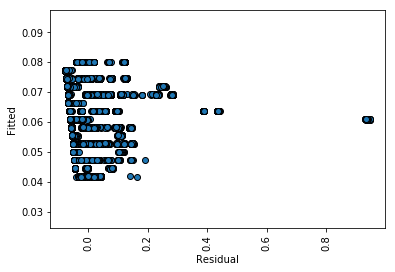

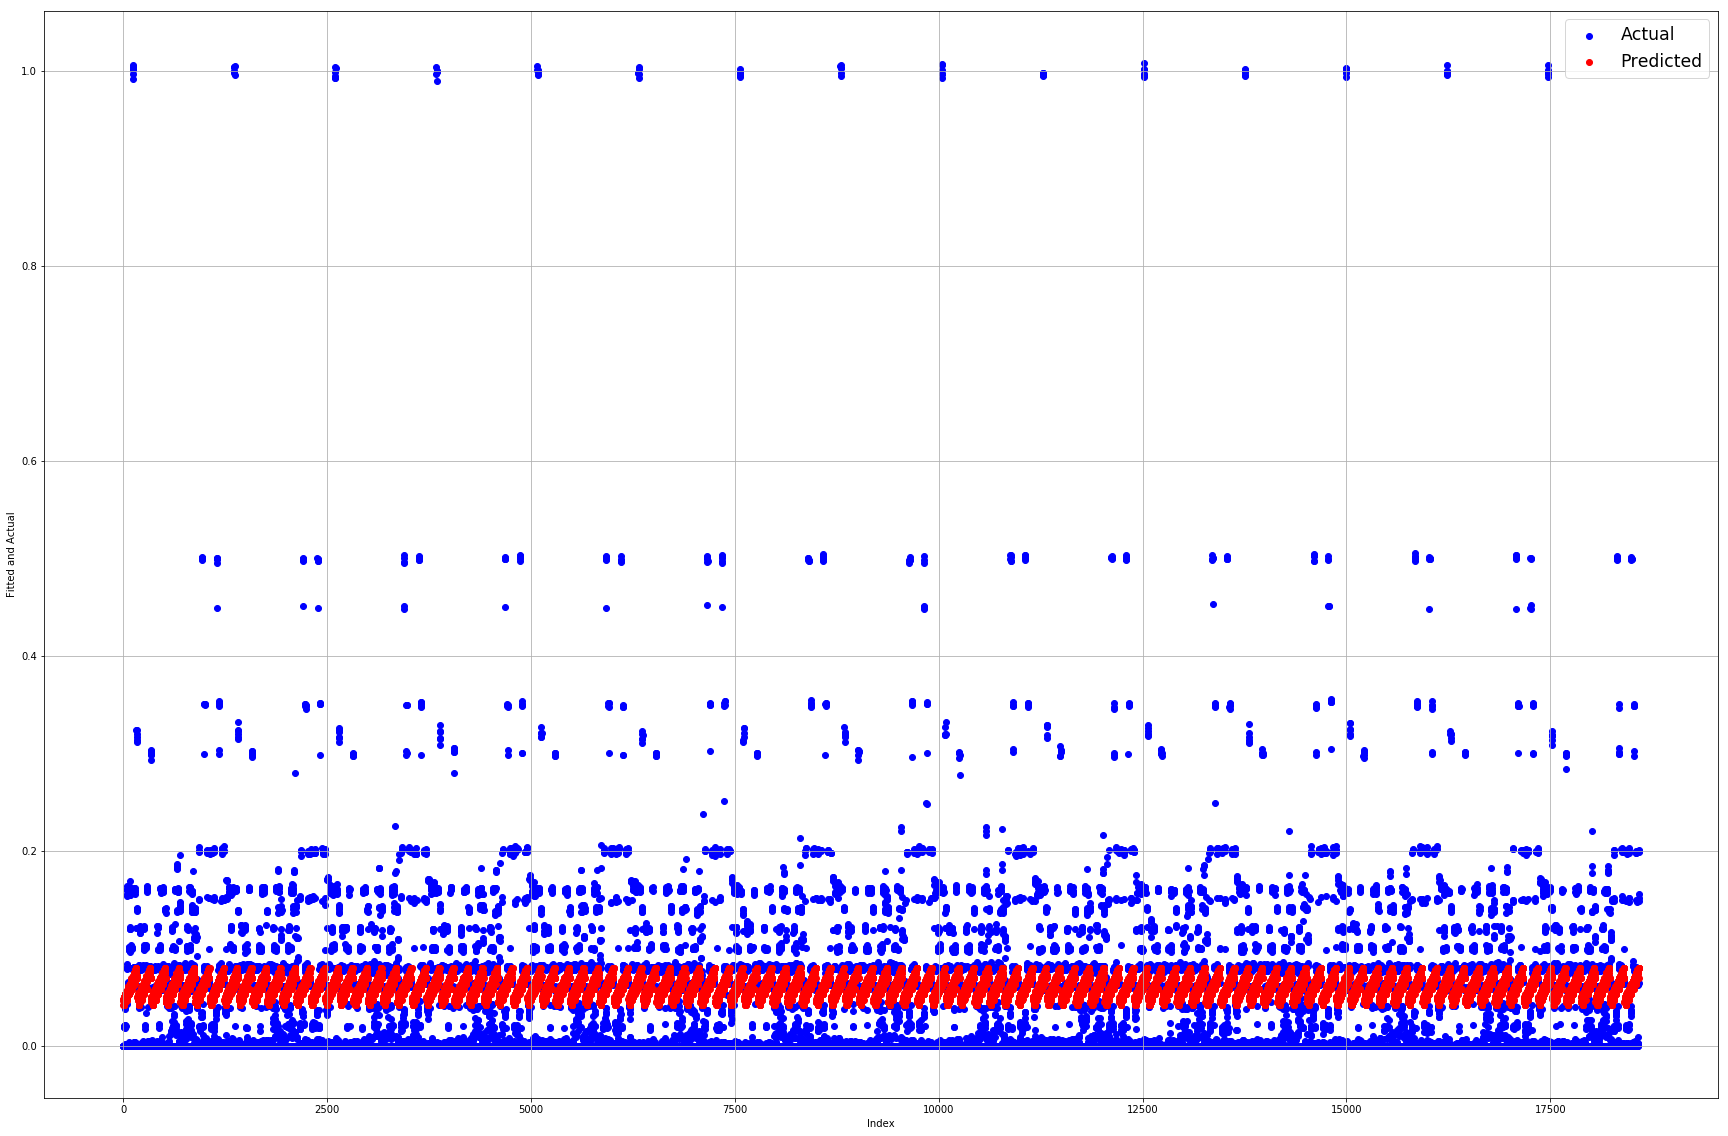

In [28]:
#Plot graph as Fitted vs Actual
plt.figure()
plt.scatter(x=y_actual, y=y_pred, edgecolors=(0, 0, 0))
plt.xlabel('Actual')
plt.ylabel('Fitted')

#Plot residual
residual = y_actual - y_pred

plt.figure()
plt.xticks(rotation='vertical')
plt.scatter(x=residual, y=y_pred, edgecolors=(0, 0, 0))
plt.xlabel('Residual')
plt.ylabel('Fitted')
plt.xlim((min(residual) - 0.05, max(residual) +0.05))

#Plot graph as Value vs Index
plt.figure(figsize=((30,20)))
plt.grid(True)
p1 = plt.scatter(y=y_actual, x=range(0,len(y_pred)), color= 'blue')
p2 = plt.scatter(y=y_pred, x=range(0,len(y_pred)), color = 'red')
plt.legend((p1, p2), ('Actual', 'Predicted'), fontsize = 'xx-large')

plt.xlabel('Index')
plt.ylabel('Fitted and Actual')

## Section 2.a.iv

In [30]:
## Preprocessing features
from sklearn.preprocessing import OneHotEncoder

# Iterate through encoders
def get_bit(byteval,idx):
    return ((byteval&(1<<idx))!=0)

def get_enc_index(val):
    index = []
    for i in xrange(0,5):
        if(get_bit(val, i)):
            index.append(i)            
    return index

In [31]:
linReg = LinearRegression(normalize = True)
kf = KFold(n_splits = 10, shuffle = True, random_state = 42)
y_actual = df_1d.loc[ : , lambda df_1d : y].as_matrix()

# Do all scalar separate (val = 0).  < -- done in part i
ave_RMSE_train = []
ave_RMSE_train.append(0.103587470756)
ave_RMSE_test = []
ave_RMSE_test.append(0.103635058768)

for i in xrange(1, 32, 1):
    print i
    categorical_features = get_enc_index(i)
    enc = OneHotEncoder(categorical_features=categorical_features)
    enc.fit(features)
    enc_features = enc.transform(features).toarray()
    
    #linear regression and kfolds
    sum_RMSE_train = 0
    sum_RMSE_test = 0

    for trainIndex, testIndex in kf.split(enc_features):
        # Set up training data
        x_trainSet = enc_features[trainIndex]
        y_trainSet = df_1d.loc[trainIndex, lambda df_1d : y]
        # Set up testing data
        x_testSet = enc_features[testIndex]
        y_testSet = df_1d.loc[testIndex, lambda df_1d : y] # actual

        # Train model using training sets
        linReg.fit(x_trainSet, y_trainSet)

        # Make predictions using the testing set
        y_pred_train = linReg.predict(x_trainSet)
        y_pred_test = linReg.predict(x_testSet)

        # Calculating RMSE
        sum_RMSE_train = sum_RMSE_train + mean_squared_error(y_trainSet, y_pred_train)
        sum_RMSE_test = sum_RMSE_test + mean_squared_error(y_testSet, y_pred_test)

    ave_RMSE_train.append(sqrt(sum_RMSE_train / 10))
    ave_RMSE_test.append(sqrt(sum_RMSE_test / 10))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


Text(0,0.5,u'RMSE')

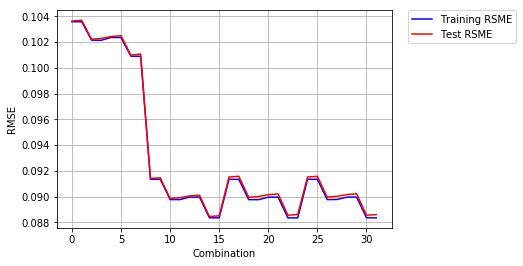

In [30]:
#Plot graph as RMSE vs Combination
plt.figure()
plt.grid(True)
plt.plot(range(0,len(ave_RMSE_train)),ave_RMSE_train, color= 'blue', label = 'Training RSME')
plt.plot(range(0,len(ave_RMSE_test)),ave_RMSE_test, color = 'red', label = 'Test RSME')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0) 

plt.xlabel('Combination')
plt.ylabel('RMSE')

In [31]:
#grab best combination
print 'Best Combination Index:', np.argmin(ave_RMSE_test)

# best model
linReg = LinearRegression(normalize = True)
categorical_features = get_enc_index(np.argmin(ave_RMSE_test))
enc = OneHotEncoder(categorical_features=categorical_features)
enc.fit(features)
enc_features = enc.transform(features).toarray()

#linear regression and kfolds
sum_RMSE_train = 0
sum_RMSE_test = 0
y_actual = df_1d.loc[ : , lambda df_1d : y].as_matrix()
for trainIndex, testIndex in kf.split(enc_features):
    # Set up training data
    x_trainSet = enc_features[trainIndex]
    y_trainSet = df_1d.loc[trainIndex, lambda df_1d : y]
    # Set up testing data
    x_testSet = enc_features[testIndex]
    y_testSet = df_1d.loc[testIndex, lambda df_1d : y] # actual

    # Train model using training sets
    linReg.fit(x_trainSet, y_trainSet)

    # Make predictions using the testing set
    y_pred_train = linReg.predict(x_trainSet)
    y_pred_test = linReg.predict(x_testSet)

    # Calculating RMSE
    sum_RMSE_train = sum_RMSE_train + mean_squared_error(y_trainSet, y_pred_train)
    sum_RMSE_test = sum_RMSE_test + mean_squared_error(y_testSet, y_pred_test)

RMSE_train = sqrt(sum_RMSE_train / 10)
RMSE_test = sqrt(sum_RMSE_test / 10)
print 'Training RMSE:', RMSE_train
print 'Test RMSE:', RMSE_test

#cross validation returns prediction
linReg.fit(enc_features, y_actual)
y_pred = linReg.predict(enc_features)
print linReg.coef_
print linReg.intercept_

Best Combination Index: 14
Training RMSE: 0.088345881677
Test RMSE: 0.0884444370415
[[ 4.17379097e+09  4.17379097e+09  4.17379097e+09  4.17379097e+09
   4.17379097e+09  4.17379097e+09  4.17379097e+09 -7.43656070e+09
  -7.43656070e+09 -7.43656070e+09 -7.43656070e+09 -7.43656070e+09
  -7.43656070e+09  1.26896876e+11  1.26896876e+11  1.26896876e+11
   1.26896876e+11  1.26896876e+11  4.39090930e-06  4.53246590e-05]]
[-1.23634107e+11]


Text(0,0.5,u'Fitted and Actual')

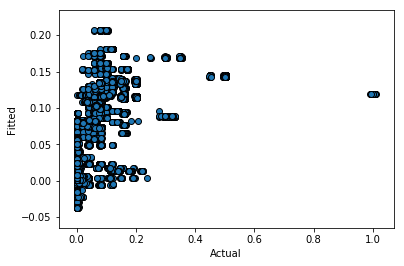

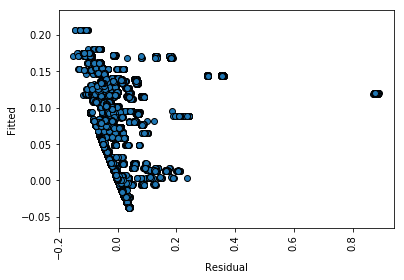

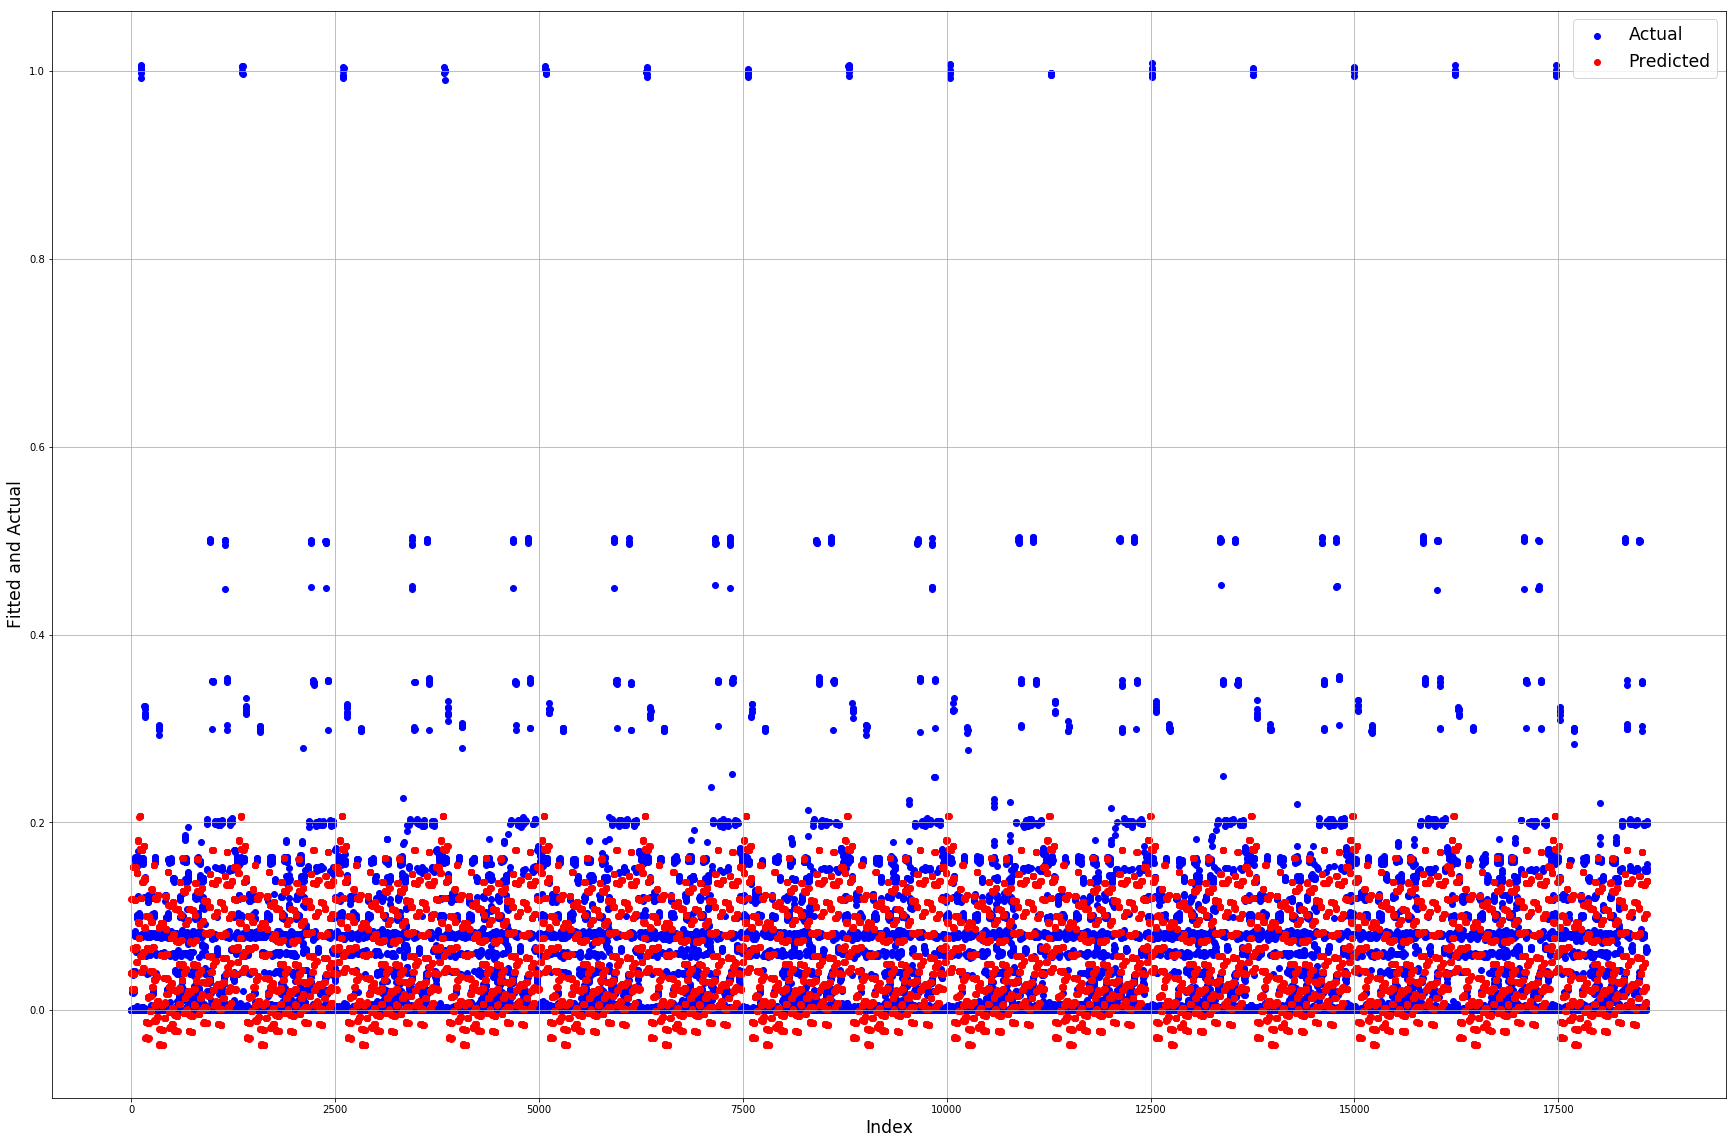

In [43]:
#Plot graph as Fitted vs Actual
plt.figure()
plt.scatter(x=y_actual, y=y_pred, edgecolors=(0, 0, 0))
plt.xlabel('Actual')
plt.ylabel('Fitted')

#Plot residual
residual = y_actual - y_pred

plt.figure()
plt.xticks(rotation='vertical')
plt.scatter(x=residual, y=y_pred, edgecolors=(0, 0, 0))
plt.xlabel('Residual')
plt.ylabel('Fitted')
plt.xlim((min(residual) - 0.05, max(residual) +0.05))

#Plot graph as Value vs Index
plt.figure(figsize=((30,20)))
plt.grid(True)
p1 = plt.scatter(y=y_actual, x=range(0,len(y_pred)), color= 'blue')
p2 = plt.scatter(y=y_pred, x=range(0,len(y_pred)), color = 'red')
plt.legend((p1, p2), ('Actual', 'Predicted'), fontsize = 'xx-large')

plt.xlabel('Index', fontsize = 'xx-large')
plt.ylabel('Fitted and Actual', fontsize = 'xx-large')

## Section 2.a.v

In [44]:
# Controlling ill-conditioning and over-fiting

from sklearn.linear_model import RidgeCV

# Ridge regularizer
# Example from github
tuningAlpha = [ 0.01, 0.001, 0.0001, 0.00001]
ridge = RidgeCV(normalize=True, alphas=tuningAlpha, cv=10)

kf = KFold(n_splits = 10, shuffle = True, random_state = 42)
y_actual = df_1d.loc[ : , lambda df_1d : y].as_matrix()

ave_RMSE_train = []
ave_RMSE_test = []
optimal_alpha = []
optimal_coefficients = []

In [45]:
# Do all scalar separate (val = 0)
sum_RMSE_train = 0
sum_RMSE_test = 0

for trainIndex, testIndex in kf.split(df_1d):
    # Set up training data
    x_trainSet = df_1d.loc[trainIndex, lambda df_1d : x]
    y_trainSet = df_1d.loc[trainIndex, lambda df_1d : y]
    # Set up testing data
    x_testSet = df_1d.loc[testIndex, lambda df_1d : x]
    y_testSet = df_1d.loc[testIndex, lambda df_1d : y] # actual

    # Train model using training sets
    ridge.fit(x_trainSet, y_trainSet)

    # Make predictions using the testing set
    y_pred_train = ridge.predict(x_trainSet)
    y_pred_test = ridge.predict(x_testSet)

    # Calculating RMSE
    sum_RMSE_train = sum_RMSE_train + mean_squared_error(y_trainSet, y_pred_train)
    sum_RMSE_test = sum_RMSE_test + mean_squared_error(y_testSet, y_pred_test)

ave_RMSE_train.append(sqrt(sum_RMSE_train / 10))
ave_RMSE_test.append(sqrt(sum_RMSE_test / 10))
optimal_alpha.append(ridge.alpha_)
optimal_coefficients.append(ridge.coef_)

In [46]:
#gathering 1-31
for i in xrange(1, 32, 1):
    print i
    categorical_features = get_enc_index(i)
    enc = OneHotEncoder(categorical_features=categorical_features)
    enc.fit(features)
    enc_features = enc.transform(features).toarray()
    
    #linear regression and kfolds
    sum_RMSE_train = 0
    sum_RMSE_test = 0

    for trainIndex, testIndex in kf.split(enc_features):
        # Set up training data
        x_trainSet = enc_features[trainIndex]
        y_trainSet = df_1d.loc[trainIndex, lambda df_1d : y]
        # Set up testing data
        x_testSet = enc_features[testIndex]
        y_testSet = df_1d.loc[testIndex, lambda df_1d : y] # actual

        # Train model using training sets
        ridge.fit(x_trainSet, y_trainSet)

        # Make predictions using the testing set
        y_pred_train = ridge.predict(x_trainSet)
        y_pred_test = ridge.predict(x_testSet)

        # Calculating RMSE
        sum_RMSE_train = sum_RMSE_train + mean_squared_error(y_trainSet, y_pred_train)
        sum_RMSE_test = sum_RMSE_test + mean_squared_error(y_testSet, y_pred_test)

    ave_RMSE_train.append(sqrt(sum_RMSE_train / 10))
    ave_RMSE_test.append(sqrt(sum_RMSE_test / 10))
    optimal_alpha.append(ridge.alpha_)
    optimal_coefficients.append(ridge.coef_)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [47]:
#grab best combination
print 'Best Combination Index:', np.argmin(ave_RMSE_test)
print 'Optimal Alpha', optimal_alpha[np.argmin(ave_RMSE_test)]
print 'Optimal Coefficients \n', optimal_coefficients[np.argmin(ave_RMSE_test)]

Best Combination Index: 14
Optimal Alpha 0.001
Optimal Coefficients 
[[ 3.86090374e-02 -1.28407508e-02 -2.01935643e-02 -4.80278352e-03
  -5.40121879e-03  3.51209328e-03  8.46728390e-04 -2.01014446e-02
  -2.14679278e-02  8.60986073e-03  3.28558082e-02 -2.26900698e-03
   1.90640229e-03  3.89205728e-02 -1.33729089e-02 -3.98394361e-02
  -5.68815451e-02  7.20534844e-02  8.41245873e-05  7.49723425e-05]]


In [48]:
#for best alpha
categorical_features = get_enc_index(np.argmin(ave_RMSE_test))
enc = OneHotEncoder(categorical_features=categorical_features)
enc.fit(features)
enc_features = enc.transform(features).toarray()

sum_RMSE_train = 0
sum_RMSE_test = 0

for trainIndex, testIndex in kf.split(enc_features):
    # Set up training data
    x_trainSet = enc_features[trainIndex]
    y_trainSet = df_1d.loc[trainIndex, lambda df_1d : y]
    # Set up testing data
    x_testSet = enc_features[testIndex]
    y_testSet = df_1d.loc[testIndex, lambda df_1d : y] # actual

    # Train model using training sets
    ridge.fit(x_trainSet, y_trainSet)

    # Make predictions using the testing set
    y_pred_train = ridge.predict(x_trainSet)
    y_pred_test = ridge.predict(x_testSet)

    # Calculating RMSE
    sum_RMSE_train = sum_RMSE_train + mean_squared_error(y_trainSet, y_pred_train)
    sum_RMSE_test = sum_RMSE_test + mean_squared_error(y_testSet, y_pred_test)

RMSE_train = sqrt(sum_RMSE_train / 10)
RMSE_test = sqrt(sum_RMSE_test / 10)
print 'Training RMSE:', RMSE_train
print 'Test RMSE:', RMSE_test
print 'Optimal Alpha:', ridge.alpha_
print 'Optimal Coefficient:', ridge.coef_

#cross validation returns prediction
ridge.fit(enc_features, y_actual)
y_pred = ridge.predict(enc_features)
print ridge.coef_
print ridge.intercept_

Training RMSE: 0.0883403724665
Test RMSE: 0.0884480250348
Optimal Alpha: 0.001
Optimal Coefficient: [[ 3.86090374e-02 -1.28407508e-02 -2.01935643e-02 -4.80278352e-03
  -5.40121879e-03  3.51209328e-03  8.46728390e-04 -2.01014446e-02
  -2.14679278e-02  8.60986073e-03  3.28558082e-02 -2.26900698e-03
   1.90640229e-03  3.89205728e-02 -1.33729089e-02 -3.98394361e-02
  -5.68815451e-02  7.20534844e-02  8.41245873e-05  7.49723425e-05]]
[[ 3.93216160e-02 -1.28096689e-02 -2.02064398e-02 -5.20044590e-03
  -5.65794889e-03  3.31772003e-03  1.53875281e-03 -2.02817752e-02
  -2.11367874e-02  7.69157759e-03  3.33335313e-02 -2.08015010e-03
   1.91274080e-03  3.88089636e-02 -1.37557813e-02 -4.01873733e-02
  -5.71940421e-02  7.22396465e-02  1.12054231e-05  5.27874895e-05]]
[0.06010303]


Text(0,0.5,u'Fitted and Actual')

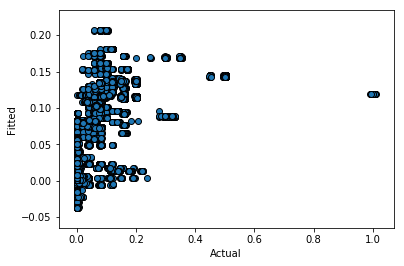

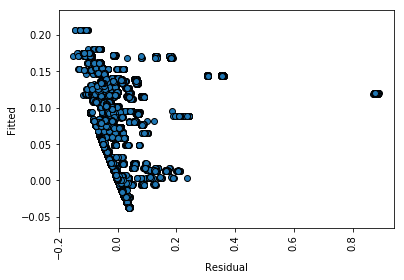

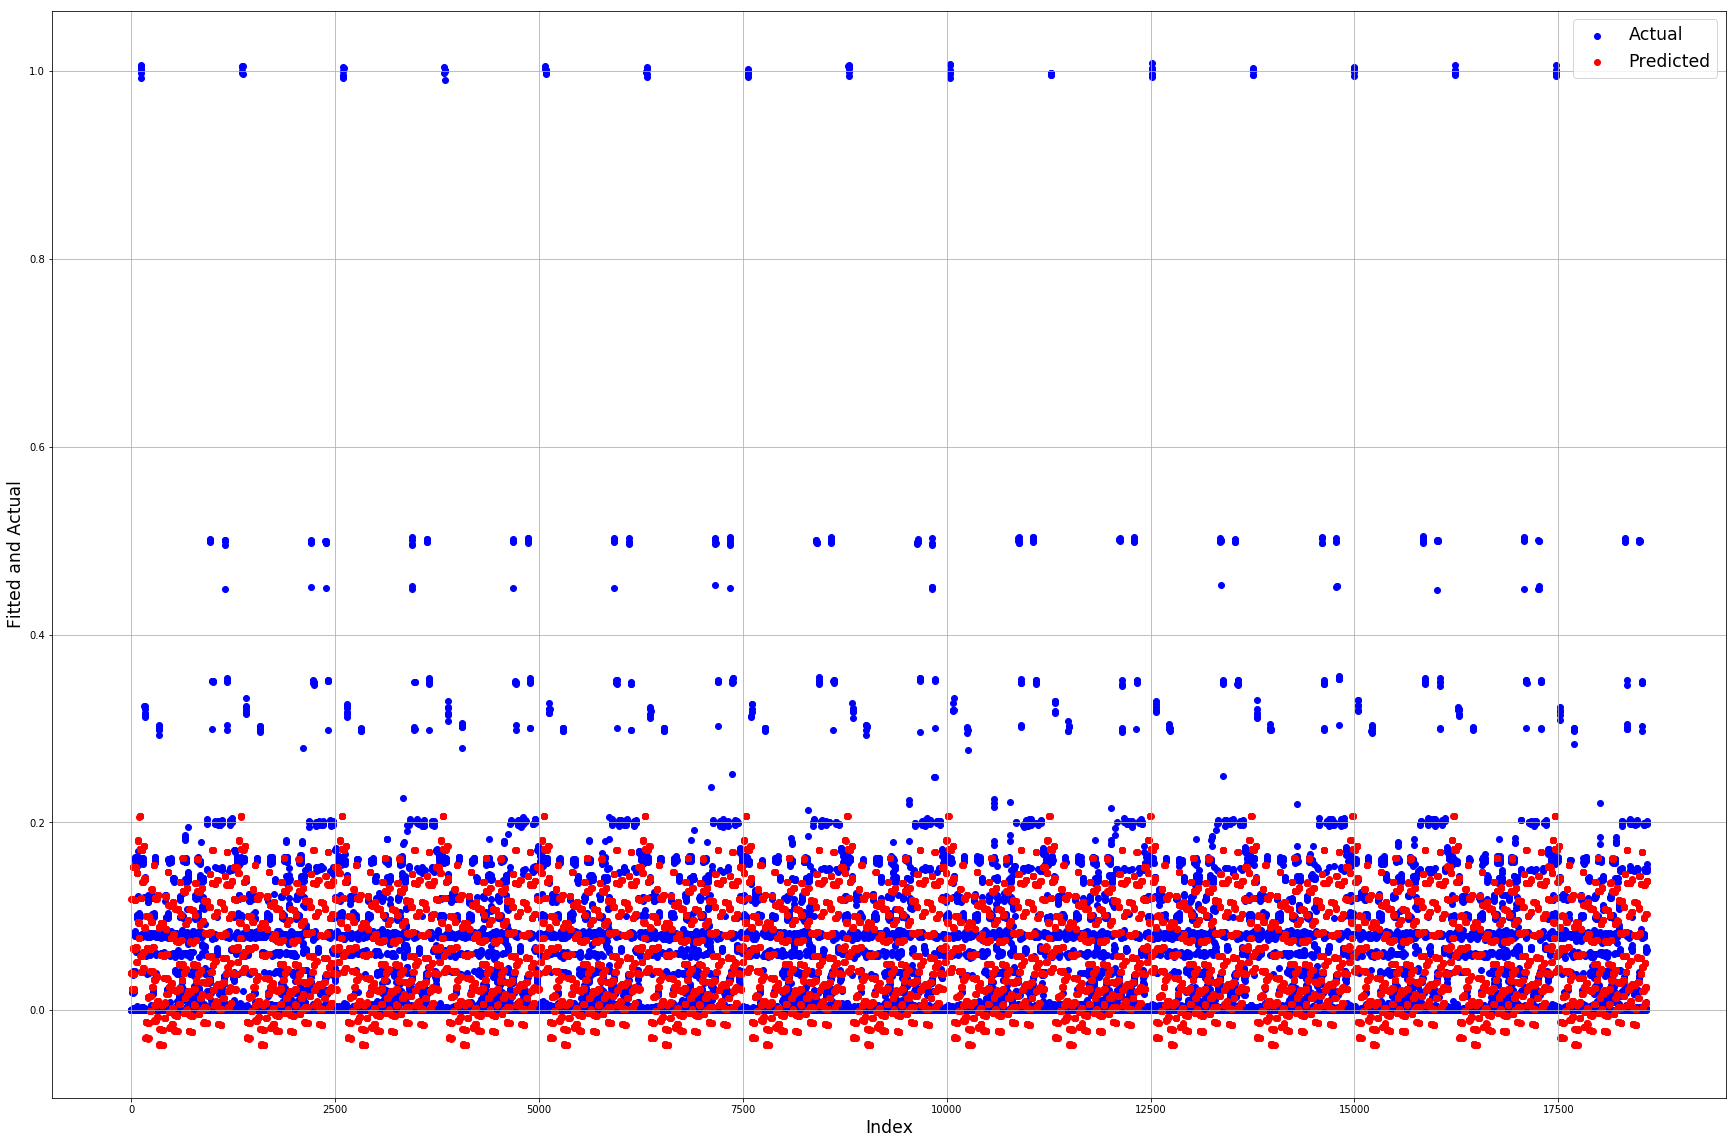

In [49]:
#Plot graph as Fitted vs Actual
plt.figure()
plt.scatter(x=y_actual, y=y_pred, edgecolors=(0, 0, 0))
plt.xlabel('Actual')
plt.ylabel('Fitted')

#Plot residual
residual = y_actual - y_pred

plt.figure()
plt.xticks(rotation='vertical')
plt.scatter(x=residual, y=y_pred, edgecolors=(0, 0, 0))
plt.xlabel('Residual')
plt.ylabel('Fitted')
plt.xlim((min(residual) - 0.05, max(residual) +0.05))

#Plot graph as Value vs Index
plt.figure(figsize=((30,20)))
plt.grid(True)
p1 = plt.scatter(y=y_actual, x=range(0,len(y_pred)), color= 'blue')
p2 = plt.scatter(y=y_pred, x=range(0,len(y_pred)), color = 'red')
plt.legend((p1, p2), ('Actual', 'Predicted'), fontsize = 'xx-large')

plt.xlabel('Index', fontsize = 'xx-large')
plt.ylabel('Fitted and Actual', fontsize = 'xx-large')

In [50]:
#Lasso Regularizer
from sklearn.linear_model import LassoCV

# lasso.fit(features,y_actual.ravel())
# prediction = lasso.predict(features)

tuningAlpha = [0.00001, 0.000001, 0.0000001, 0.00000001]
lasso = LassoCV(normalize=True, alphas=tuningAlpha, cv=10)

kf = KFold(n_splits = 10, shuffle = True, random_state = 42)
y_actual = df_1d.loc[ : , lambda df_1d : y].as_matrix()

ave_RMSE_train = []
ave_RMSE_test = []
optimal_alpha = []
optimal_coefficients = []

In [51]:
# Do all scalar separate (val = 0)
sum_RMSE_train = 0
sum_RMSE_test = 0

for trainIndex, testIndex in kf.split(df_1d):
    # Set up training data
    x_trainSet = df_1d.loc[trainIndex, lambda df_1d : x]
    y_trainSet = df_1d.loc[trainIndex, lambda df_1d : y]
    # Set up testing data
    x_testSet = df_1d.loc[testIndex, lambda df_1d : x]
    y_testSet = df_1d.loc[testIndex, lambda df_1d : y] # actual

    # Train model using training sets
    lasso.fit(x_trainSet, y_trainSet.as_matrix().ravel())

    # Make predictions using the testing set
    y_pred_train = lasso.predict(x_trainSet)
    y_pred_test = lasso.predict(x_testSet)

    # Calculating RMSE
    sum_RMSE_train = sum_RMSE_train + mean_squared_error(y_trainSet, y_pred_train)
    sum_RMSE_test = sum_RMSE_test + mean_squared_error(y_testSet, y_pred_test)

ave_RMSE_train.append(sqrt(sum_RMSE_train / 10))
ave_RMSE_test.append(sqrt(sum_RMSE_test / 10))
optimal_alpha.append(lasso.alpha_)
optimal_coefficients.append(lasso.coef_)

In [52]:
#gathering 1-31
for i in xrange(1, 32, 1):
    print i
    categorical_features = get_enc_index(i)
    enc = OneHotEncoder(categorical_features=categorical_features)
    enc.fit(features)
    enc_features = enc.transform(features).toarray()
    
    sum_RMSE_train = 0
    sum_RMSE_test = 0

    for trainIndex, testIndex in kf.split(enc_features):
        # Set up training data
        x_trainSet = enc_features[trainIndex]
        y_trainSet = df_1d.loc[trainIndex, lambda df_1d : y]
        # Set up testing data
        x_testSet = enc_features[testIndex]
        y_testSet = df_1d.loc[testIndex, lambda df_1d : y] # actual

        # Train model using training sets
        lasso.fit(x_trainSet, y_trainSet.as_matrix().ravel())

        # Make predictions using the testing set
        y_pred_train = lasso.predict(x_trainSet)
        y_pred_test = lasso.predict(x_testSet)

        # Calculating RMSE
        sum_RMSE_train = sum_RMSE_train + mean_squared_error(y_trainSet, y_pred_train)
        sum_RMSE_test = sum_RMSE_test + mean_squared_error(y_testSet, y_pred_test)

    ave_RMSE_train.append(sqrt(sum_RMSE_train / 10))
    ave_RMSE_test.append(sqrt(sum_RMSE_test / 10))
    optimal_alpha.append(lasso.alpha_)
    optimal_coefficients.append(lasso.coef_)
    
    

1
2


c:\python27\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [53]:
#grab best combination
print 'Best Combination Index:', np.argmin(ave_RMSE_test)
print 'Optimal Alpha', optimal_alpha[np.argmin(ave_RMSE_test)]
print 'Optimal Coefficients \n', optimal_coefficients[np.argmin(ave_RMSE_test)]

Best Combination Index: 14
Optimal Alpha 1e-07
Optimal Coefficients 
[ 4.34169578e-02 -8.01284851e-03 -1.53740701e-02 -0.00000000e+00
 -5.68732752e-04  8.28897404e-03  5.62210441e-03 -2.19697114e-02
 -2.33348256e-02  6.70957716e-03  3.09762446e-02 -4.11929324e-03
  0.00000000e+00  4.82493147e-02 -3.70109870e-03 -2.98606851e-02
 -4.65866984e-02  8.27309487e-02  8.11841727e-05  2.02756387e-05]


In [54]:
#for best alpha
categorical_features = get_enc_index(np.argmin(ave_RMSE_test))
enc = OneHotEncoder(categorical_features=categorical_features)
enc.fit(features)
enc_features = enc.transform(features).toarray()

sum_RMSE_train = 0
sum_RMSE_test = 0

for trainIndex, testIndex in kf.split(enc_features):
    # Set up training data
    x_trainSet = enc_features[trainIndex]
    y_trainSet = df_1d.loc[trainIndex, lambda df_1d : y]
    # Set up testing data
    x_testSet = enc_features[testIndex]
    y_testSet = df_1d.loc[testIndex, lambda df_1d : y] # actual

    # Train model using training sets
    lasso.fit(x_trainSet, y_trainSet)

    # Make predictions using the testing set
    y_pred_train = lasso.predict(x_trainSet)
    y_pred_test = lasso.predict(x_testSet)

    # Calculating RMSE
    sum_RMSE_train = sum_RMSE_train + mean_squared_error(y_trainSet, y_pred_train)
    sum_RMSE_test = sum_RMSE_test + mean_squared_error(y_testSet, y_pred_test)

RMSE_train = sqrt(sum_RMSE_train / 10)
RMSE_test = sqrt(sum_RMSE_test / 10)
print 'Training RMSE:', RMSE_train
print 'Test RMSE:', RMSE_test
print 'Optimal Alpha:', lasso.alpha_
print 'Optimal Coefficient:', lasso.coef_

#cross validation returns prediction
lasso.fit(enc_features, y_actual)
y_pred = lasso.predict(enc_features)
print lasso.coef_
print lasso.intercept_

c:\python27\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training RMSE: 0.088340881368
Test RMSE: 0.0884452706288
Optimal Alpha: 1e-07
Optimal Coefficient: [ 4.34169578e-02 -8.01284851e-03 -1.53740701e-02 -0.00000000e+00
 -5.68732752e-04  8.28897404e-03  5.62210441e-03 -2.19697114e-02
 -2.33348256e-02  6.70957716e-03  3.09762446e-02 -4.11929324e-03
  0.00000000e+00  4.82493147e-02 -3.70109870e-03 -2.98606851e-02
 -4.65866984e-02  8.27309487e-02  8.11841727e-05  2.02756387e-05]
[ 4.45272382e-02 -7.58046276e-03 -1.49864394e-02 -0.00000000e+00
 -4.25940727e-04  8.49168220e-03  6.71119442e-03 -2.21534079e-02
 -2.30077033e-02  5.78281258e-03  3.14460629e-02 -3.93477048e-03
  0.00000000e+00  4.86290616e-02 -3.60289726e-03 -2.97384730e-02
 -4.64392428e-02  8.33630681e-02  8.05485342e-06  0.00000000e+00]
0.04711379236438298


Text(0,0.5,u'Fitted and Actual')

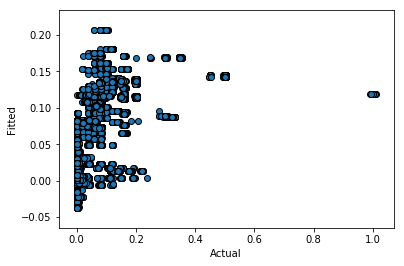

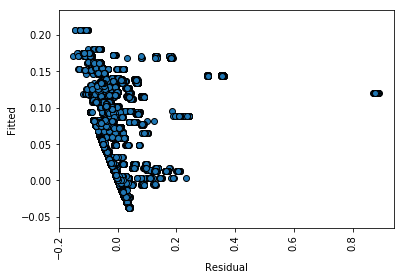

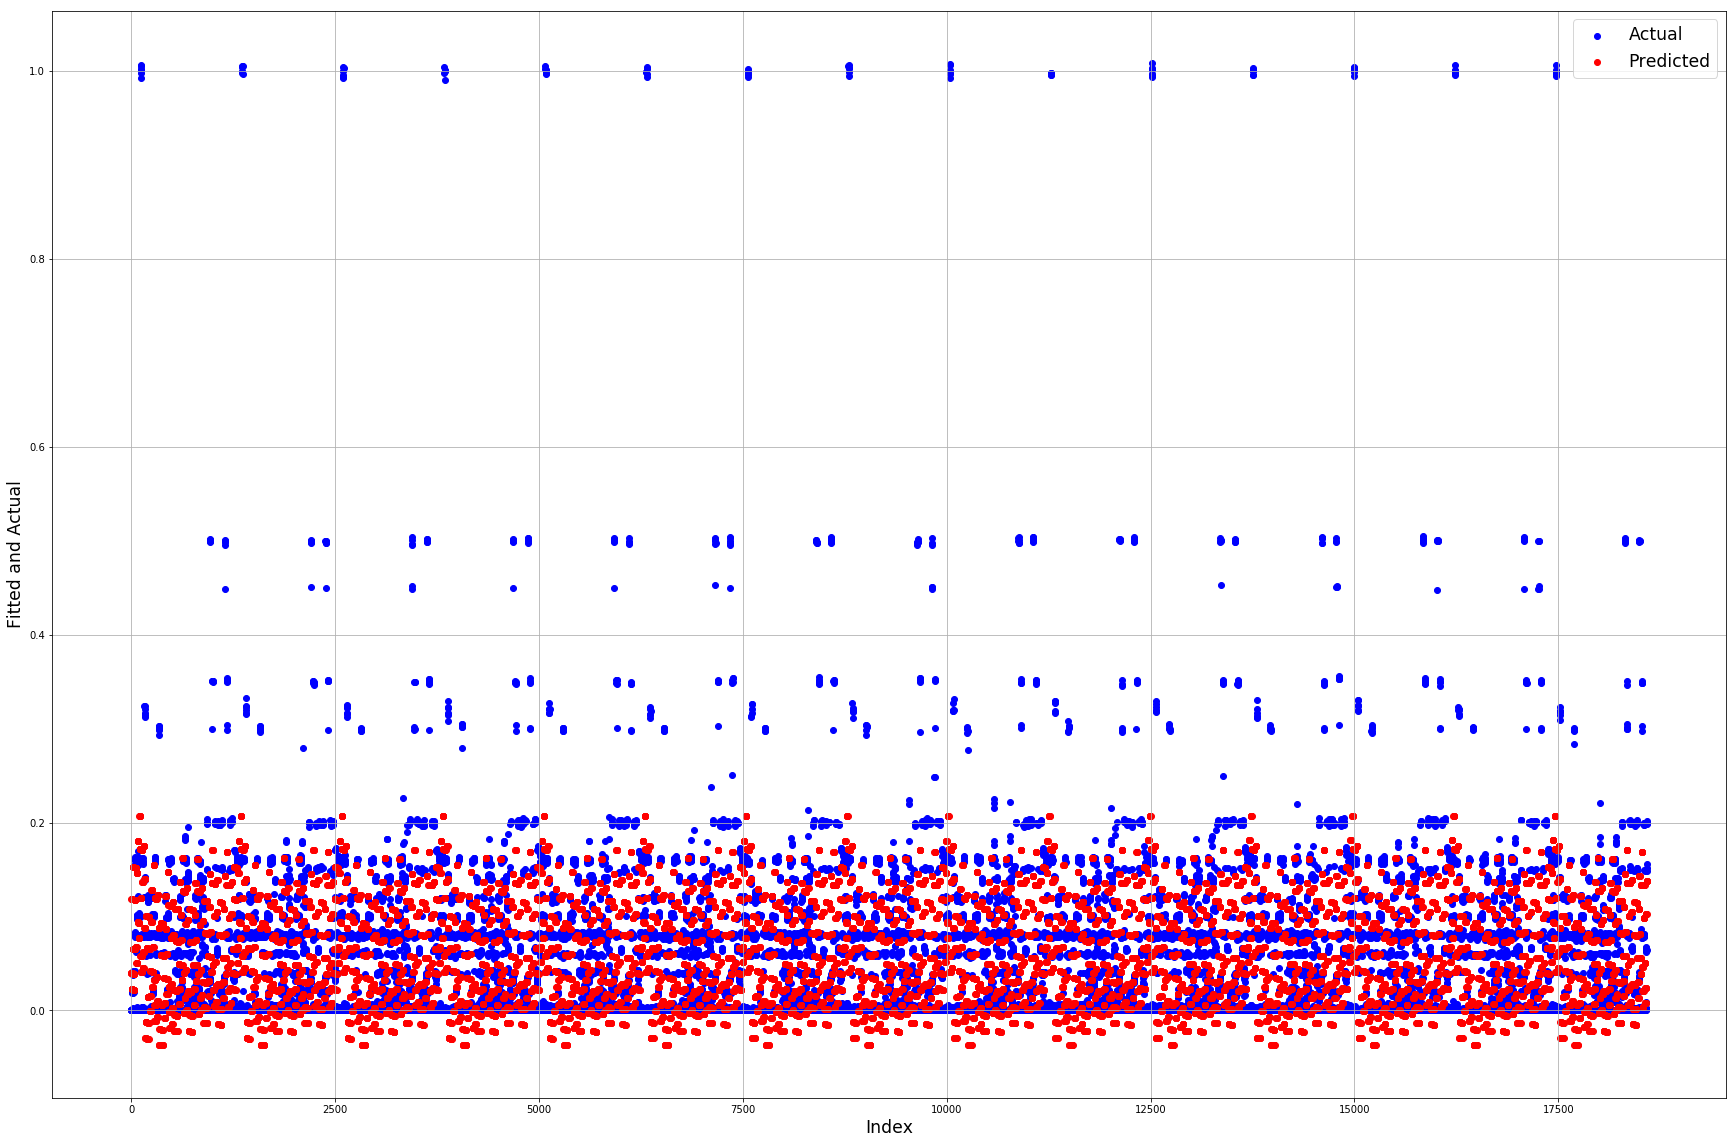

In [56]:
#Plot graph as Fitted vs Actual
plt.figure()
plt.scatter(x=y_actual, y=y_pred, edgecolors=(0, 0, 0))
plt.xlabel('Actual')
plt.ylabel('Fitted')

#Plot residual
residual = y_actual.ravel() - y_pred

plt.figure()
plt.xticks(rotation='vertical')
plt.scatter(x=residual, y=y_pred, edgecolors=(0, 0, 0))
plt.xlabel('Residual')
plt.ylabel('Fitted')
plt.xlim((min(residual) - 0.05, max(residual) +0.05))

#Plot graph as Value vs Index
plt.figure(figsize=((30,20)))
plt.grid(True)
p1 = plt.scatter(y=y_actual, x=range(0,len(y_pred)), color= 'blue')
p2 = plt.scatter(y=y_pred, x=range(0,len(y_pred)), color = 'red')
plt.legend((p1, p2), ('Actual', 'Predicted'), fontsize = 'xx-large')

plt.xlabel('Index', fontsize = 'xx-large')
plt.ylabel('Fitted and Actual', fontsize = 'xx-large')

In [57]:
# Elastic Net Regularizer
from sklearn.linear_model import ElasticNetCV

tune_l1_ratio = [0.001, 0.01, 0.1, 0.15]

elastic_net = ElasticNetCV(l1_ratio=tune_l1_ratio, fit_intercept = True, precompute = 'auto')

kf = KFold(n_splits = 10, shuffle = False, random_state = 42)
y_actual = df_1d.loc[ : , lambda df_1d : y].as_matrix()

ave_RMSE_train = []
ave_RMSE_test = []
optimal_coefficients = []
optimal_l1_ratio = []

In [59]:
# Do all scalar separate (val = 0)
sum_RMSE_train = 0
sum_RMSE_test = 0

for trainIndex, testIndex in kf.split(df_1d):
    # Set up training data
    x_trainSet = df_1d.loc[trainIndex, lambda df_1d : x]
    y_trainSet = df_1d.loc[trainIndex, lambda df_1d : y]
    # Set up testing data
    x_testSet = df_1d.loc[testIndex, lambda df_1d : x]
    y_testSet = df_1d.loc[testIndex, lambda df_1d : y] # actual

    # Train model using training sets
    elastic_net.fit(x_trainSet, y_trainSet)

    # Make predictions using the testing set
    y_pred_train = elastic_net.predict(x_trainSet)
    y_pred_test = elastic_net.predict(x_testSet)

    # Calculating RMSE
    sum_RMSE_train = sum_RMSE_train + mean_squared_error(y_trainSet, y_pred_train)
    sum_RMSE_test = sum_RMSE_test + mean_squared_error(y_testSet, y_pred_test)

ave_RMSE_train.append(sqrt(sum_RMSE_train / 10))
ave_RMSE_test.append(sqrt(sum_RMSE_test / 10))
optimal_alpha.append(elastic_net.alpha_)
optimal_coefficients.append(elastic_net.coef_)
optimal_l1_ratio.append(elastic_net.l1_ratio_)

In [60]:
#gathering 1-31
for i in xrange(1, 32, 1):
    print i
    categorical_features = get_enc_index(i)
    enc = OneHotEncoder(categorical_features=categorical_features)
    enc.fit(features)
    enc_features = enc.transform(features).toarray()
    
    #linear regression and kfolds
    sum_RMSE_train = 0
    sum_RMSE_test = 0

    for trainIndex, testIndex in kf.split(enc_features):
        # Set up training data
        x_trainSet = enc_features[trainIndex]
        y_trainSet = df_1d.loc[trainIndex, lambda df_1d : y]
        # Set up testing data
        x_testSet = enc_features[testIndex]
        y_testSet = df_1d.loc[testIndex, lambda df_1d : y] # actual

        # Train model using training sets
        elastic_net.fit(x_trainSet, y_trainSet)

        # Make predictions using the testing set
        y_pred_train = elastic_net.predict(x_trainSet)
        y_pred_test = elastic_net.predict(x_testSet)

        # Calculating RMSE
        sum_RMSE_train = sum_RMSE_train + mean_squared_error(y_trainSet, y_pred_train)
        sum_RMSE_test = sum_RMSE_test + mean_squared_error(y_testSet, y_pred_test)

    ave_RMSE_train.append(sqrt(sum_RMSE_train / 10))
    ave_RMSE_test.append(sqrt(sum_RMSE_test / 10))
    optimal_alpha.append(elastic_net.alpha_)
    optimal_coefficients.append(elastic_net.coef_)
    optimal_l1_ratio.append(elastic_net.l1_ratio_)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [61]:
#grab best combination
print 'Best Combination Index:', np.argmin(ave_RMSE_test)
print 'Optimal Lambda', optimal_l1_ratio[np.argmin(ave_RMSE_test)]
print 'Optimal Coefficients \n', optimal_coefficients[np.argmin(ave_RMSE_test)]

Best Combination Index: 15
Optimal Lambda 0.1
Optimal Coefficients 
[ 4.45634551e-02 -7.06266514e-03 -1.46108281e-02 -0.00000000e+00
 -0.00000000e+00  8.63754309e-03  6.81267218e-03 -2.09755534e-02
 -2.16568987e-02  6.12064372e-03  3.30406577e-02 -2.98807575e-03
  1.36711097e-03  5.10098702e-02 -0.00000000e+00 -2.83195643e-02
 -4.44030102e-02  8.35265952e-02  9.02541915e-06 -2.68513858e-06]


In [62]:
#for best alpha
categorical_features = get_enc_index(np.argmin(ave_RMSE_test))
enc = OneHotEncoder(categorical_features=categorical_features)
enc.fit(features)
enc_features = enc.transform(features).toarray()

sum_RMSE_train = 0
sum_RMSE_test = 0

for trainIndex, testIndex in kf.split(enc_features):
    # Set up training data
    x_trainSet = enc_features[trainIndex]
    y_trainSet = df_1d.loc[trainIndex, lambda df_1d : y]
    # Set up testing data
    x_testSet = enc_features[testIndex]
    y_testSet = df_1d.loc[testIndex, lambda df_1d : y] # actual

    # Train model using training sets
    elastic_net.fit(x_trainSet, y_trainSet)

    # Make predictions using the testing set
    y_pred_train = elastic_net.predict(x_trainSet)
    y_pred_test = elastic_net.predict(x_testSet)

    # Calculating RMSE
    sum_RMSE_train = sum_RMSE_train + mean_squared_error(y_trainSet, y_pred_train)
    sum_RMSE_test = sum_RMSE_test + mean_squared_error(y_testSet, y_pred_test)

RMSE_train = sqrt(sum_RMSE_train / 10)
RMSE_test = sqrt(sum_RMSE_test / 10)
print 'Training RMSE:', RMSE_train
print 'Test RMSE:', RMSE_test
print 'Optimal Coefficient:', elastic_net.coef_

#cross validation returns prediction
elastic_net.fit(enc_features, y_actual)
y_pred = elastic_net.predict(enc_features)
print elastic_net.intercept_

Training RMSE: 0.0883379346702
Test RMSE: 0.0885043174859
Optimal Coefficient: [-4.14502281e-04 -0.00000000e+00  2.90000119e-05 -0.00000000e+00
  9.54293071e-06 -0.00000000e+00  0.00000000e+00  5.01337498e-04
  0.00000000e+00  0.00000000e+00 -1.95299549e-04  4.00700423e-04
 -0.00000000e+00 -3.37363260e-04  0.00000000e+00  4.45783853e-02
 -7.04766737e-03 -1.45958308e-02 -0.00000000e+00 -1.40373862e-05
  8.62216335e-03  6.79729360e-03 -2.09726524e-02 -2.16539195e-02
  6.12354370e-03  3.30400911e-02 -2.98964642e-03  1.36563493e-03
  5.10089723e-02 -0.00000000e+00 -2.83201912e-02 -4.44034886e-02
  8.35262366e-02 -2.70556996e-06]
0.042650478766432846


Text(0,0.5,u'Fitted and Actual')

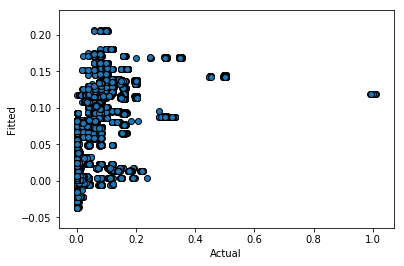

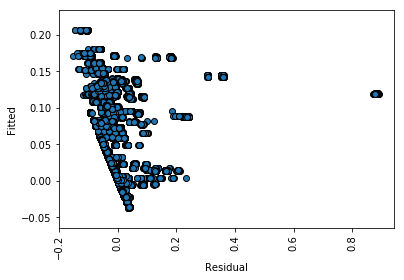

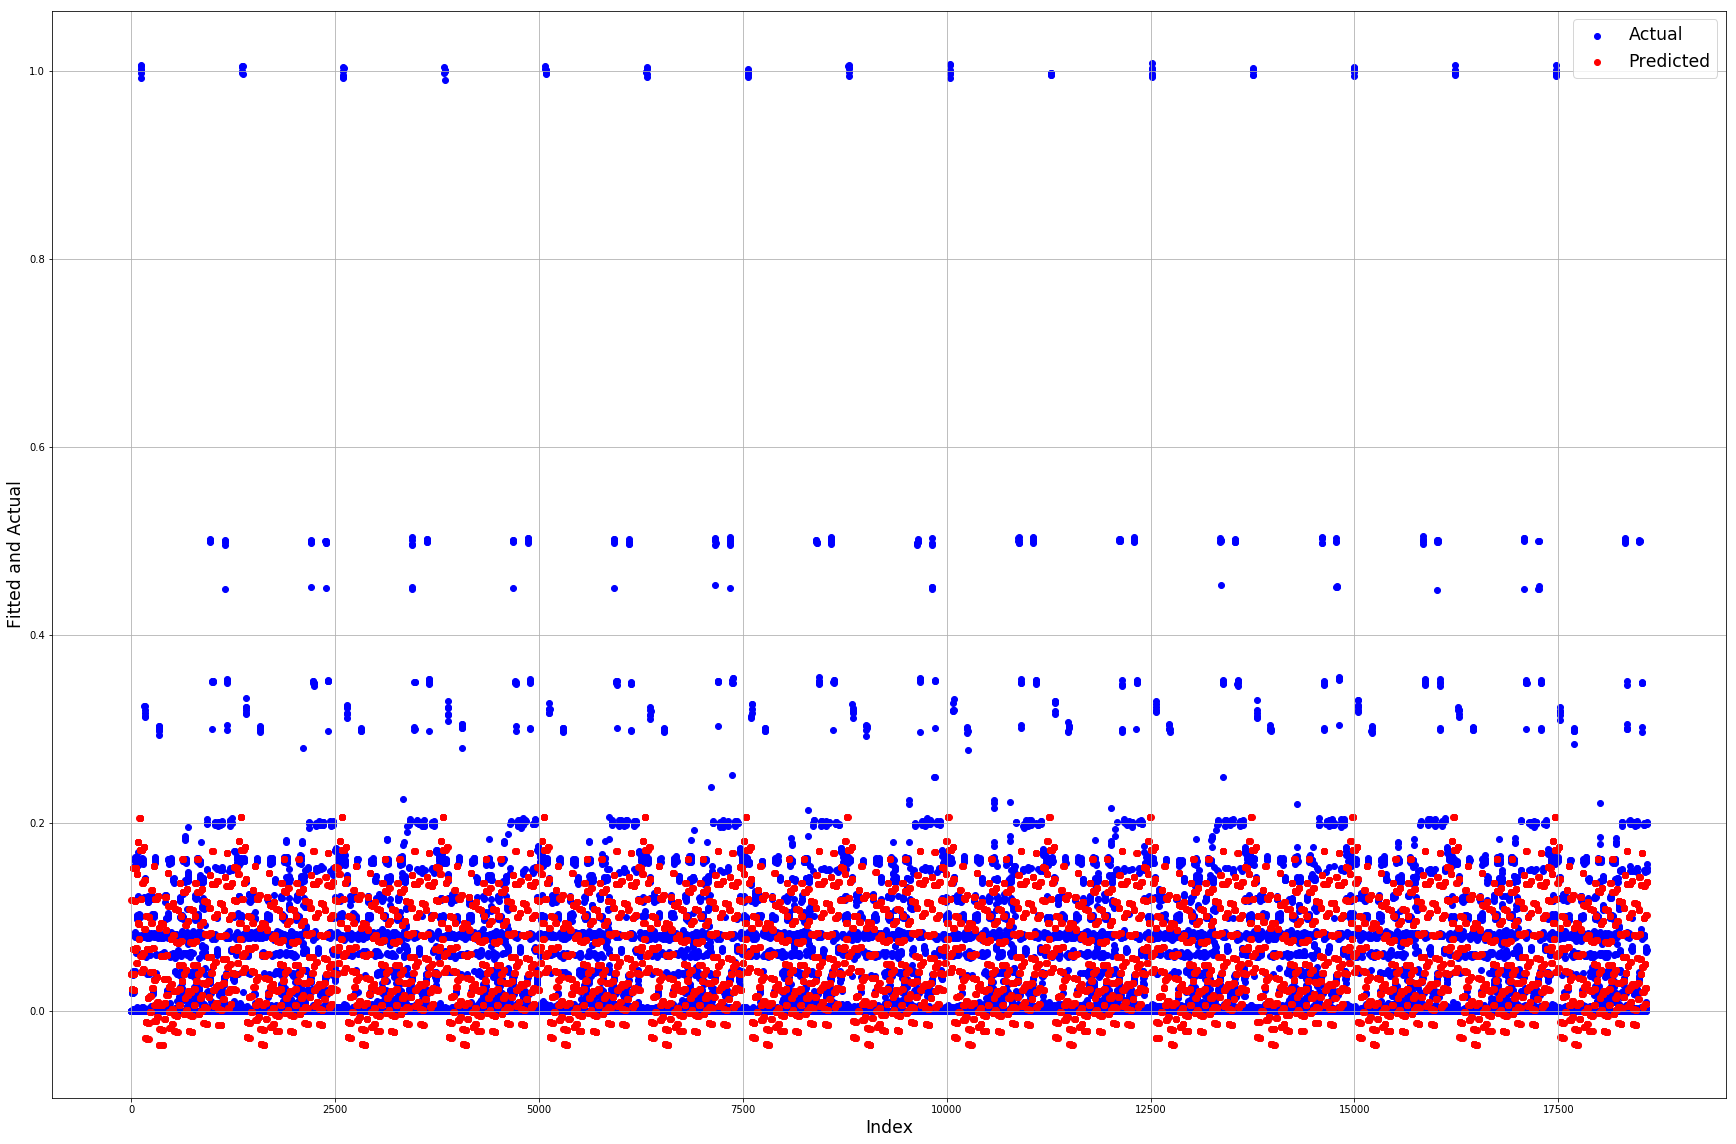

In [64]:
#Plot graph as Fitted vs Actual
plt.figure()
plt.scatter(x=y_actual, y=y_pred, edgecolors=(0, 0, 0))
plt.xlabel('Actual')
plt.ylabel('Fitted')

#Plot residual
residual = y_actual.ravel() - y_pred

plt.figure()
plt.xticks(rotation='vertical')
plt.scatter(x=residual, y=y_pred, edgecolors=(0, 0, 0))
plt.xlabel('Residual')
plt.ylabel('Fitted')
plt.xlim((min(residual) - 0.05, max(residual) +0.05))

#Plot graph as Value vs Index
plt.figure(figsize=((30,20)))
plt.grid(True)
p1 = plt.scatter(y=y_actual, x=range(0,len(y_pred)), color= 'blue')
p2 = plt.scatter(y=y_pred, x=range(0,len(y_pred)), color = 'red')
plt.legend((p1, p2), ('Actual', 'Predicted'), fontsize = 'xx-large')

plt.xlabel('Index', fontsize = 'xx-large')
plt.ylabel('Fitted and Actual', fontsize = 'xx-large')

## Section 2e

In [65]:
# KNN Regularizer
from sklearn.neighbors import KNeighborsRegressor

kf = KFold(n_splits = 10, shuffle = False, random_state = 42)
y_actual = df_1d.loc[ : , lambda df_1d : y].as_matrix()

ave_RMSE_train = []
ave_RMSE_test = []
optimal_parameters = []

In [66]:
for tune_neigh in xrange(1, 151, 1):
    neigh = KNeighborsRegressor(n_neighbors=tune_neigh)
    
    sum_RMSE_train = 0
    sum_RMSE_test = 0

    for trainIndex, testIndex in kf.split(df_1d):
        # Set up training data
        x_trainSet = df_1d.loc[trainIndex, lambda df_1d : x]
        y_trainSet = df_1d.loc[trainIndex, lambda df_1d : y]
        # Set up testing data
        x_testSet = df_1d.loc[testIndex, lambda df_1d : x]
        y_testSet = df_1d.loc[testIndex, lambda df_1d : y] # actual

        # Train model using training sets
        neigh.fit(x_trainSet, y_trainSet)

        # Make predictions using the testing set
        y_pred_train = neigh.predict(x_trainSet)
        y_pred_test = neigh.predict(x_testSet)

        # Calculating RMSE
        sum_RMSE_train = sum_RMSE_train + mean_squared_error(y_trainSet, y_pred_train)
        sum_RMSE_test = sum_RMSE_test + mean_squared_error(y_testSet, y_pred_test)

    ave_RMSE_train.append(sqrt(sum_RMSE_train / 10))
    ave_RMSE_test.append(sqrt(sum_RMSE_test / 10))
    optimal_parameters.append(neigh.get_params)

In [67]:
#grab best combination
print 'Best Combination Index:', np.argmin(ave_RMSE_test)
print 'Optimal Parameters', optimal_parameters[np.argmin(ave_RMSE_test)]

Best Combination Index: 94
Optimal Parameters <bound method KNeighborsRegressor.get_params of KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=95, p=2,
          weights='uniform')>


In [68]:
neigh = KNeighborsRegressor(n_neighbors=95)
    
sum_RMSE_train = 0
sum_RMSE_test = 0

for trainIndex, testIndex in kf.split(df_1d):
    # Set up training data
    x_trainSet = df_1d.loc[trainIndex, lambda df_1d : x]
    y_trainSet = df_1d.loc[trainIndex, lambda df_1d : y]
    # Set up testing data
    x_testSet = df_1d.loc[testIndex, lambda df_1d : x]
    y_testSet = df_1d.loc[testIndex, lambda df_1d : y] # actual

    # Train model using training sets
    neigh.fit(x_trainSet, y_trainSet)

    # Make predictions using the testing set
    y_pred_train = neigh.predict(x_trainSet)
    y_pred_test = neigh.predict(x_testSet)

    # Calculating RMSE
    sum_RMSE_train = sum_RMSE_train + mean_squared_error(y_trainSet, y_pred_train)
    sum_RMSE_test = sum_RMSE_test + mean_squared_error(y_testSet, y_pred_test)

RMSE_train = sqrt(sum_RMSE_train / 10)
RMSE_test = sqrt(sum_RMSE_test / 10)
print 'Training RMSE:', RMSE_train
print 'Test RMSE:', RMSE_test

#cross validation returns prediction
neigh.fit(df_1d, y_actual)
y_pred = neigh.predict(df_1d)

Training RMSE: 0.0849706352258
Test RMSE: 0.0852556952782


Text(0,0.5,u'Fitted and Actual')

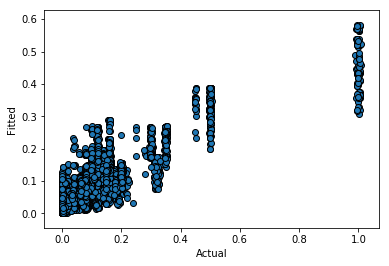

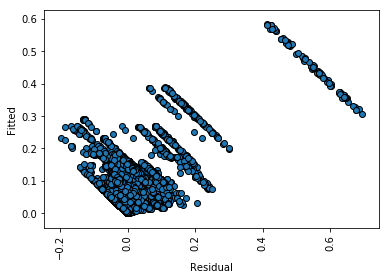

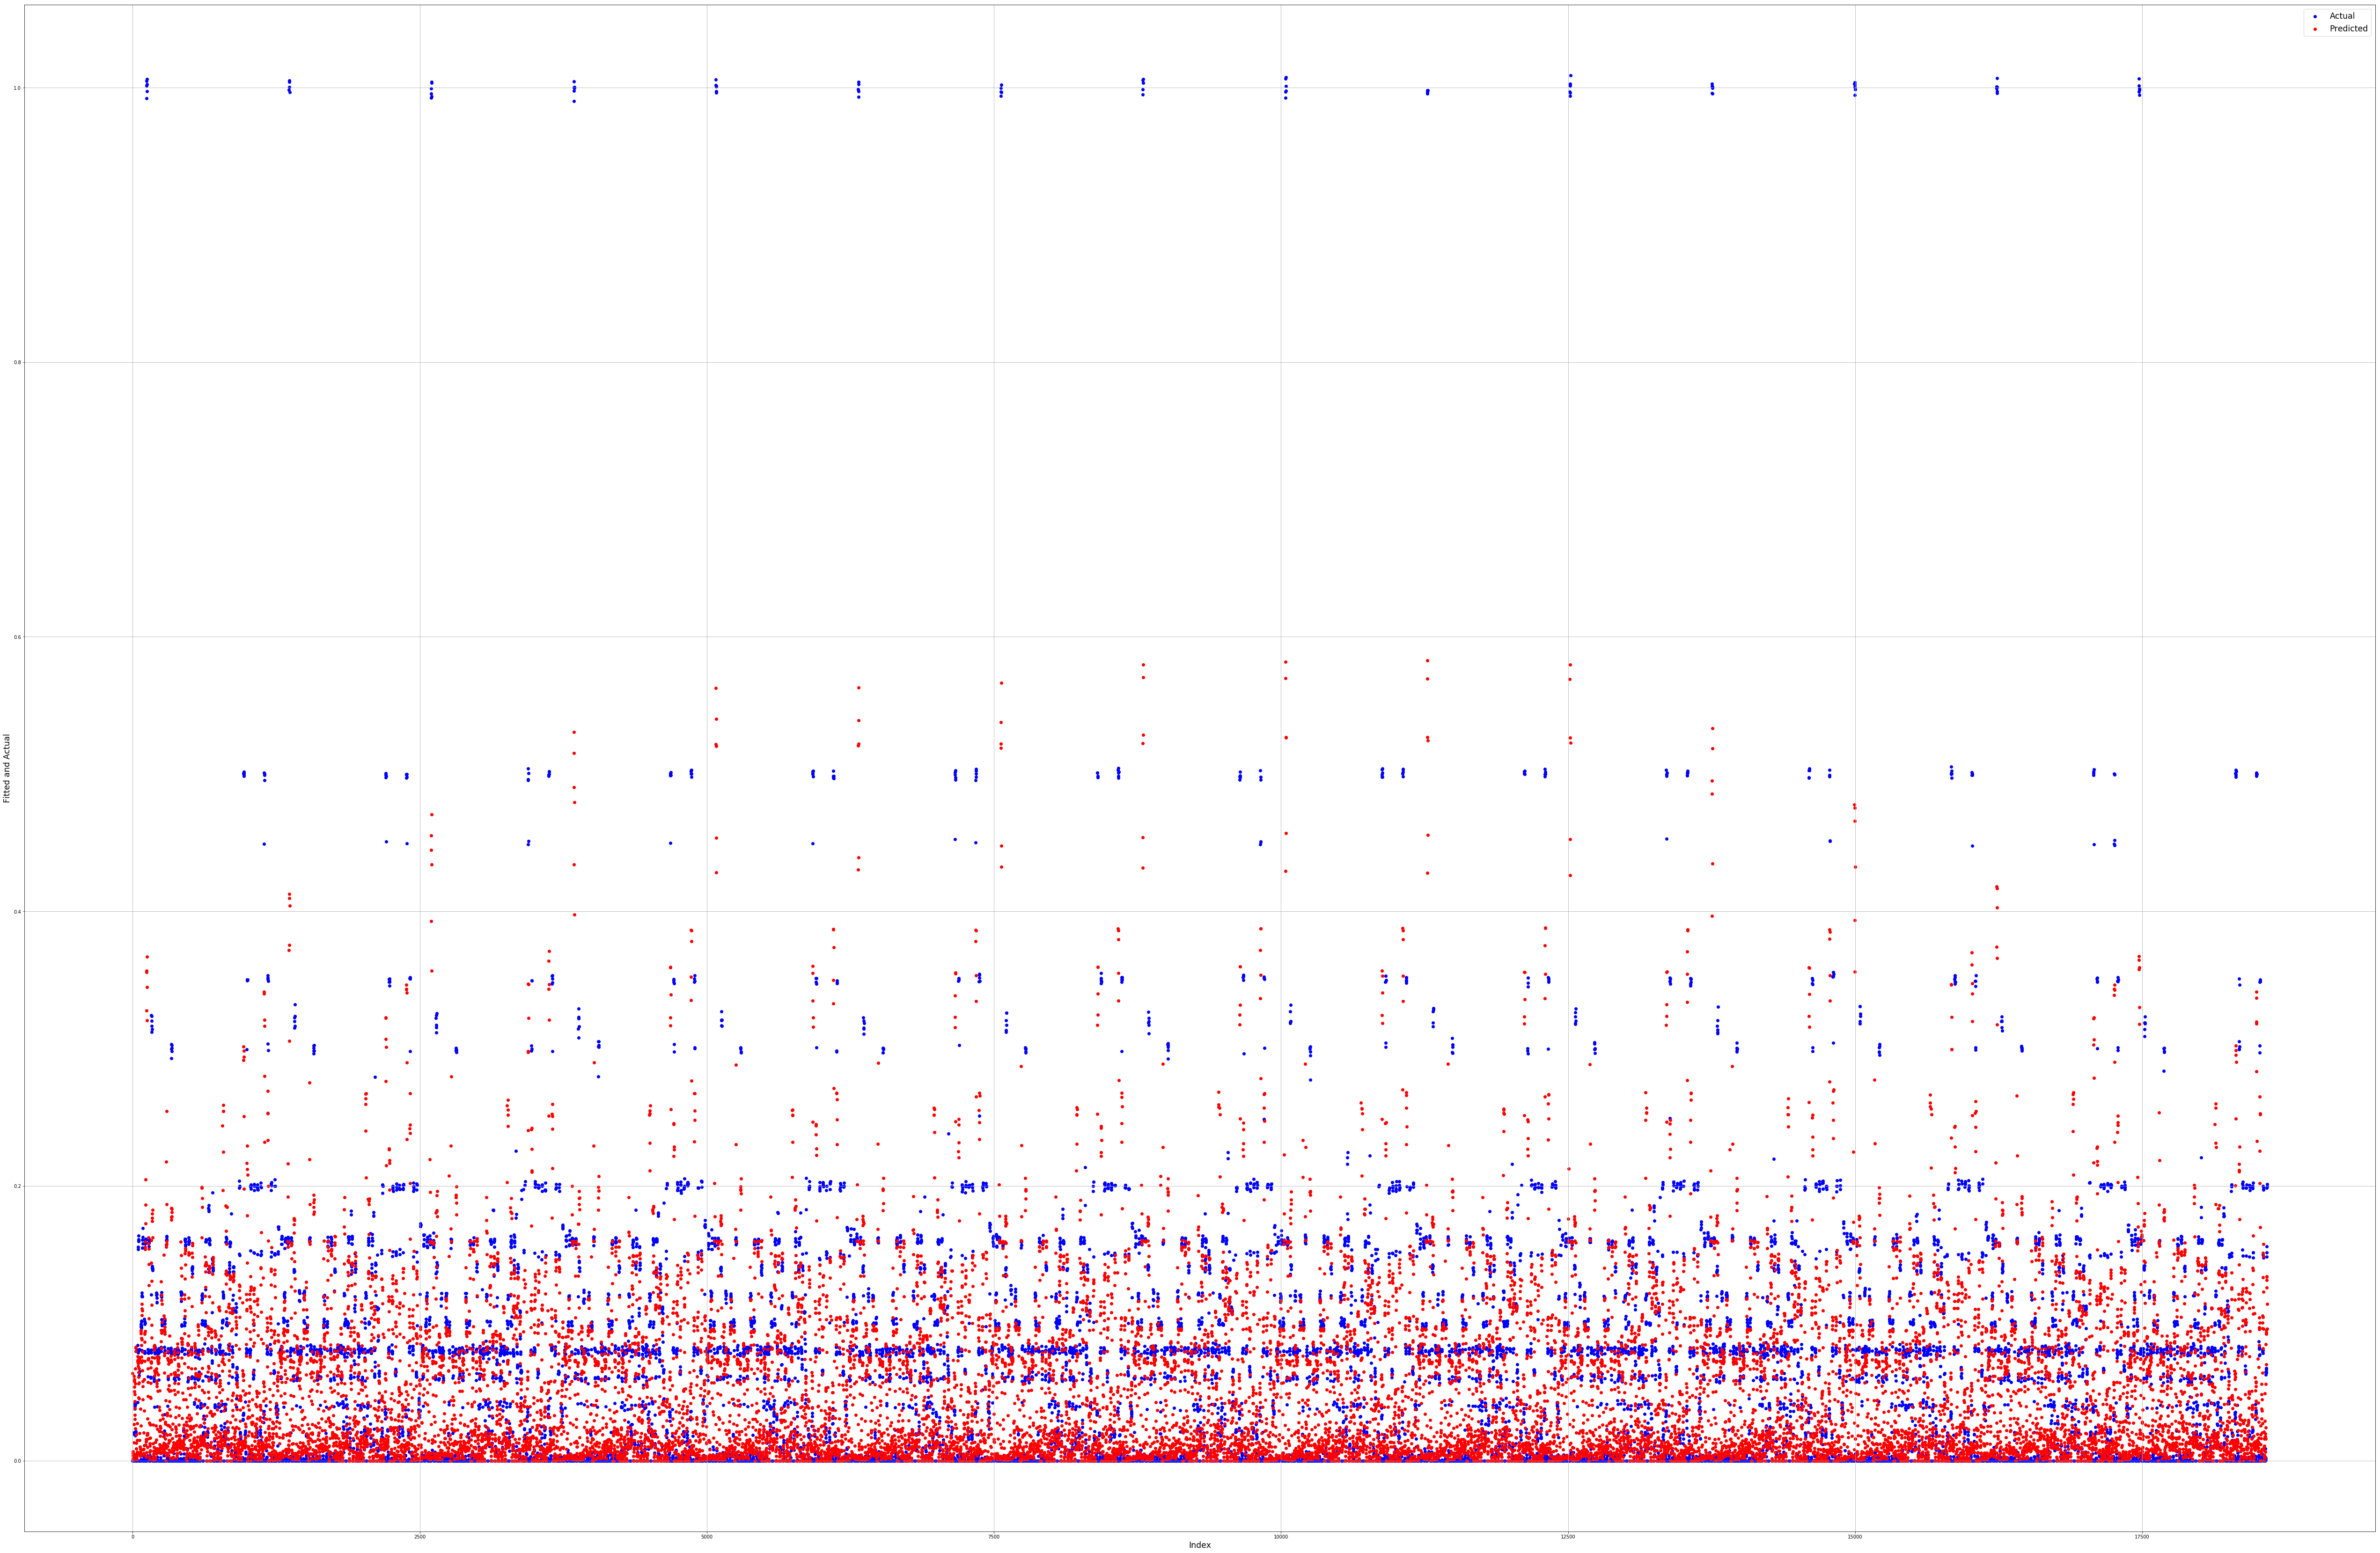

In [69]:
#Plot graph as Fitted vs Actual
plt.figure()
plt.scatter(x=y_actual, y=y_pred, edgecolors=(0, 0, 0))
plt.xlabel('Actual')
plt.ylabel('Fitted')

#Plot residual
residual = y_actual - y_pred

plt.figure()
plt.xticks(rotation='vertical')
plt.scatter(x=residual, y=y_pred, edgecolors=(0, 0, 0))
plt.xlabel('Residual')
plt.ylabel('Fitted')
plt.xlim((min(residual) - 0.05, max(residual) +0.05))

#Plot graph as Value vs Index
plt.figure(figsize=((90,60)))
plt.grid(True)
p1 = plt.scatter(y=y_actual, x=range(0,len(y_pred)), color= 'blue')
p2 = plt.scatter(y=y_pred, x=range(0,len(y_pred)), color = 'red')
plt.legend((p1, p2), ('Actual', 'Predicted'), fontsize = 'xx-large')

plt.xlabel('Index', fontsize = 'xx-large')
plt.ylabel('Fitted and Actual', fontsize = 'xx-large')